# **Lab 03: Khai thác và trực quan hóa dữ liệu**

### **Danh sách các thành viên**

<center>

|         Họ tên         |   MSSV   |
| :--------------------- | :------: |
| Trần Nguyễn Nhật Cường | 22127048 |
|    Nguyễn Công Tuấn    | 22127436 |
|     Trần Đăng Tuấn     | 22127438 |

</center>

## **Cài đặt và sử dụng các thư viện cần thiết**

In [32]:
! pip install matplotlib pandas seaborn wbgapi scikit-learn

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wbgapi as wb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:.2f}'.format

**`matplotlib`** được dùng để vẽ biểu đồ trong Python. Có thể dùng để vẽ các loại biểu đồ như
histogram, biểu đồ tán xạ (scatter plot), biểu đồ đường (line chart) và biểu đồ cột (bar chart),...

**`pandas`** được dùng để xử lý và phân tích dữ liệu dạng bảng và cung cấp cấu trúc dữ liệu như
DataFrame và Series để dễ thao tác

**`seaborn`** dùng để vẽ biểu đồ dựa trên thư viện matplotlib nhưng biểu đồ sẽ trông đẹp hơn và cũng hỗ trợ các loại biểu đồ thống kê như violin plot, box plot, heatmap

**`wbgapi`** dùng để lấy/truy cập dữ liệu từ ngân hàng thế giới (World Bank).

**`sklearn (scikit-learn)`** là thư viện học máy phổ biến trong Python, được sử dụng để thực hiện các tác vụ học máy và xử lý dữ liệu. Trong đồ án này, các thành phần sau của sklearn được sử dụng:
- **`sklearn.cluster.KMeans`**: Cung cấp thuật toán KMeans để gom nhóm dữ liệu thành các cụm dựa trên sự tương đồng, được sử dụng để phân loại các nền kinh tế thành các nhóm.
- **`sklearn.metrics.silhouette_score`**: Dùng để tính điểm Silhouette, một chỉ số đánh giá chất lượng của việc gom nhóm, giúp xác định số lượng cụm tối ưu bằng cách đo lường mức độ tách biệt giữa các cụm.
- **`sklearn.preprocessing.StandardScaler`**: Dùng để chuẩn hóa dữ liệu, đưa các giá trị về cùng thang đo (trung bình bằng 0 và độ lệch chuẩn bằng 1), đảm bảo các chỉ số kinh tế có trọng số công bằng khi áp dụng thuật toán gom nhóm.

## **Thu thập dữ liệu**

**Nền tảng thu thập** - *World Development Indicators* từ *World Bank*

**Phương pháp thư thập** - Gọi *APIs* từ **WBGAPI** - một package để truy cập vào dữ liệu *World Bank* - *Ngân hàng thế giới*

**Cách lưu trữ dữ liệu sau khi thu thập** - Lưu thành file **`wdi_2000_2020_VNM`**, **`wdi_2000_2020_USA`**  và **`wdi_2000_2020_JPN`** tương ứng với 3 quôc gia Việt Nam, Hoa Kỳ và Nhật Bản

In [34]:
INDICATORS = {
    # Education
    'SE.PRM.UNER.FE':       'Children out of school, primary, female',
    'SE.PRM.UNER.MA':       'Children out of school, primary, male',
    'SE.XPD.TOTL.GD.ZS':    'Government expenditure on education, total (% of GDP)',
    'SE.XPD.PRIM.PC.ZS':    'Government expenditure per student, primary (% of GDP per capita)',
    'SE.XPD.SECO.PC.ZS':    'Government expenditure per student, secondary (% of GDP per capita)',
    'SE.XPD.TERT.PC.ZS':    'Government expenditure per student, tertiary (% of GDP per capita)',
    'SE.PRM.GINT.FE.ZS':    'Gross intake ratio in first grade of primary education, female (% of relevant age group)',
    'SE.PRM.GINT.MA.ZS':    'Gross intake ratio in first grade of primary education, male (% of relevant age group)',
    'SL.TLF.TOTL.FE.ZS':    'Labor force, female (% of total labor force)',
    'SL.TLF.TOTL.IN':       'Labor force, total',
    'SE.ADT.LITR.FE.ZS':    'Literacy rate, adult female (% of females ages 15 and above)',
    'SE.ADT.LITR.MA.ZS':    'Literacy rate, adult male (% of males ages 15 and above)',
    'SE.ADT.1524.LT.FE.ZS': 'Literacy rate, youth female (% of females ages 15-24)',
    'SE.ADT.1524.LT.MA.ZS': 'Literacy rate, youth male (% of males ages 15-24)',
    'SE.PRM.ENRL.TC.ZS':    'Pupil-teacher ratio, primary',
    'SE.PRM.REPT.FE.ZS':    'Repeaters, primary, female (% of female enrollment)',
    'SE.PRM.REPT.MA.ZS':    'Repeaters, primary, male (% of male enrollment)',
    'SE.PRE.ENRR':          'School enrollment, preprimary (% gross)',
    'SE.PRM.ENRR':          'School enrollment, primary (% gross)',
    'SE.SEC.ENRR':          'School enrollment, secondary (% gross)',
    'SE.PRM.TCAQ.ZS':       'Trained teachers in primary education (% of total teachers)',
    'SL.UEM.TOTL.FE.ZS':    'Unemployment, female (% of female labor force) (modeled ILO estimate)',
    'SL.UEM.TOTL.ZS':       'Unemployment, total (% of total labor force) (modeled ILO estimate)',

    # Climate Change
    'EG.ELC.ACCS.ZS':       'Access to electricity (% of population)',
    'AG.LND.IRIG.AG.ZS':    'Agricultural irrigated land (% of total agricultural land)',
    'AG.LND.AGRI.ZS':       'Agricultural land (% of land area)',
    'NV.AGR.TOTL.ZS':       'Agriculture, forestry, and fishing, value added (% of GDP)',
    'ER.H2O.FWTL.K3':       'Annual freshwater withdrawals, total (billion cubic meters)',
    'AG.LND.ARBL.ZS':       'Arable land (% of land area)',
    'AG.YLD.CREL.KG':       'Cereal yield (kg per hectare)',
    'EG.USE.ELEC.KH.PC':    'Electric power consumption (kWh per capita)',
    'EG.USE.PCAP.KG.OE':    'Energy use (kg of oil equivalent per capita)',
    'AG.LND.FRST.ZS':       'Forest area (% of land area)',
    'AG.LND.FRST.K2':       'Forest area (sq. km)',
    'AG.LND.EL5M.ZS':       'Land area where elevation is below 5 meters (% of total land area)',
    'SP.POP.GROW':          'Population growth (annual %)',
    'EN.POP.EL5M.ZS':       'Population living in areas where elevation is below 5 meters (% of total population)',
    'SP.POP.TOTL':          'Population, total',
    'EG.ELC.RNEW.ZS':       'Renewable electricity output (% of total electricity output)',
    'EG.FEC.RNEW.ZS':       'Renewable energy consumption (% of total final energy consumption)',
    'ER.PTD.TOTL.ZS':       'Terrestrial and marine protected areas (% of total territorial area)',
    'SP.URB.TOTL':          'Urban population',
    'SP.URB.TOTL.IN.ZS':    'Urban population (% of total population)',

    # Economic and Growth
    'NY.ADJ.SVNG.GN.ZS':    'Adjusted net savings, including particulate emission damage (% of GNI)',
    'GC.DOD.TOTL.GD.ZS':    'Central government debt, total (% of GDP)',
    'BM.GSR.ROYL.CD':       'Charges for the use of intellectual property, payments (BoP, current US$)',
    'BX.GSR.ROYL.CD':       'Charges for the use of intellectual property, receipts (BoP, current US$)',
    'BN.CAB.XOKA.CD':       'Current account balance (BoP, current US$)',
    'GC.XPN.TOTL.GD.ZS':    'Expense (% of GDP)',
    'NE.EXP.GNFS.ZS':       'Exports of goods and services (% of GDP)',
    'DT.DOD.DECT.GN.ZS':    'External debt stocks (% of GNI)',
    'DT.DOD.DECT.CD':       'External debt stocks, total (DOD, current US$)',
    'BX.KLT.DINV.CD.WD':    'Foreign direct investment, net inflows (BoP, current US$)',
    'NY.GDP.MKTP.CD':       'GDP (current US$)',
    'NY.GDP.MKTP.KD.ZG':    'GDP growth (annual %)',
    'NY.GDP.PCAP.CD':       'GDP per capita (current US$)',
    'NY.GDP.PCAP.KD.ZG':    'GDP per capita growth (annual %)',
    'NY.GDP.PCAP.PP.CD':    'GDP per capita, PPP (current international $)',
    'NY.GNP.PCAP.CD':       'GNI per capita, Atlas method (current US$)',
    'NY.GNP.PCAP.PP.CD':    'GNI per capita, PPP (current international $)',
    'NY.GNP.ATLS.CD':       'GNI, Atlas method (current US$)',
    'NY.GNP.MKTP.PP.CD':    'GNI, PPP (current international $)',
    'BX.GRT.EXTA.CD.WD':    'Grants, excluding technical cooperation (BoP, current US$)',
    'NE.GDI.TOTL.ZS':       'Gross capital formation (% of GDP)',
    'NY.GNS.ICTR.ZS':       'Gross savings (% of GDP)',
    'NE.IMP.GNFS.ZS':       'Imports of goods and services (% of GDP)',
    'NV.IND.TOTL.ZS':       'Industry (including construction), value added (% of GDP)',
    'NY.GDP.DEFL.KD.ZG':    'Inflation, GDP deflator (annual %)',
    'FP.CPI.TOTL.ZG':       'Inflation, consumer prices (annual %)',
    'NV.MNF.TECH.ZS.UN':    'Medium and high-tech manufacturing value added (% manufacturing value added)',
    'DT.ODA.ODAT.GN.ZS':    'Net ODA received (% of GNI)',
    'DT.ODA.ODAT.PC.ZS':    'Net ODA received per capita (current US$)',
    'DT.ODA.ODAT.CD':       'Net official development assistance received (current US$)',
    'PA.NUS.PPP':           'PPP conversion factor, GDP (LCU per international $)',
    'BX.TRF.PWKR.CD.DT':    'Personal remittances, received (current US$)',
    'PA.NUS.PRVT.PP':       'Price level ratio of PPP conversion factor (GDP) to market exchange rate',
    'GC.REV.XGRT.GD.ZS':    'Revenue, excluding grants (% of GDP)',
    'DT.DOD.DSTC.ZS':       'Short-term debt (% of total reserves)',
    'BX.GRT.TECH.CD.WD':    'Technical cooperation grants (BoP, current US$)',
    'DT.TDS.DECT.EX.ZS':    'Total debt service (% of exports of goods, services and primary income)',
    'FI.RES.TOTL.CD':       'Total reserves (includes gold, current US$)'
}
COUNTRIES = ['USA', 'JPN', 'VNM']
START_YEAR = 2000
END_YEAR = 2020
DATASETS = {}

for country in COUNTRIES:
    data = wb.data.DataFrame(
        series=list(INDICATORS.keys()),
        economy=country,
        time=range(START_YEAR, END_YEAR + 1),
    )
    data.to_csv(f'wdi_{START_YEAR}_{END_YEAR}_{country}.csv')
    DATASETS[country] = data.reset_index()

DATASETS['USA']

,series,YR2000,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,...,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020
0,AG.LND.AGRI.ZS,45.23,45.29,45.08,45.08,45.08,45.08,45.08,45.06,45.13,...,45.13,45.41,45.47,45.53,45.59,45.65,45.71,45.58,45.46,45.33
1,AG.LND.ARBL.ZS,19.15,19.15,18.88,18.88,18.88,18.88,18.89,17.66,17.69,...,17.68,16.93,16.99,17.05,17.10,17.15,17.21,17.09,16.96,16.83
2,AG.LND.EL5M.ZS,1.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.46,NaN,NaN,NaN,NaN,NaN
3,AG.LND.FRST.K2,3035360.00,3040544.00,3045728.00,3050912.00,3056096.00,3061280.00,3066464.00,3071648.00,3076832.00,...,3089950.00,3092700.00,3095450.00,3098200.00,3100950.00,3100950.00,3097950.00,3097950.00,3097950.00,3097950.00
4,AG.LND.FRST.ZS,33.13,33.19,33.24,33.30,33.36,33.41,33.47,33.53,33.64,...,33.78,33.81,33.84,33.87,33.90,33.90,33.87,33.87,33.87,33.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,SL.UEM.TOTL.ZS,3.99,4.73,5.78,5.99,5.53,5.08,4.62,4.62,5.78,...,8.95,8.07,7.38,6.17,5.28,4.87,4.36,3.90,3.67,8.05
77,SP.POP.GROW,1.11,0.99,0.93,0.86,0.93,0.92,0.96,0.95,0.95,...,0.73,0.73,0.69,0.73,0.74,0.72,0.63,0.53,0.46,0.97
78,SP.POP.TOTL,282162411.00,284968955.00,287625193.00,290107933.00,292805298.00,295516599.00,298379912.00,301231207.00,304093966.00,...,311583481.00,313877662.00,316059947.00,318386329.00,320738994.00,323071755.00,325122128.00,326838199.00,328329953.00,331526933.00
79,SP.URB.TOTL,223069137.00,225792302.00,228400290.00,230876596.00,233532722.00,236200507.00,238999326.00,241795278.00,244607104.00,...,252208133.00,254614421.00,256953576.00,259430732.00,261950744.00,264473000.00,266788716.00,268844029.00,270737596.00,274053424.00


## **Tiền xử lý dữ liệu**

### **Định dạng lại bộ dữ liệu**

**Mục đích**: Chuyển dữ liệu từ dạng rộng (wide format) sang dạng bảng chuẩn, giúp dễ dàng phân tích theo năm và quốc gia.

**Các thực hiện**:

1. Đọc dữ liệu với mỗi chỉ số (*series*) là một hàng, các năm (*YR2000–YR2020*) là cột vào cột Year và giá trị vào cột Value.

2. Chuyển sang long format bằng cách dùng melt() để đưa năm vào cột Year và giá trị vào cột Value.

3. Chuẩn hóa dữ liệu bằng cách chuyển Year về dạng số, thay dấu chấm (.) trong tên chỉ số bằng gạch dưới (_). 
    
    Ví dụ: **AG.LND.ARBL.ZS** $\rightarrow$ **AG_LND_ARBL_ZS**.

4. Pivot lại dữ liệu bằng cách chuyển mỗi chỉ số thành một cột riêng, với Year làm cột chính.

5. Lưu kết quả sau khi đã áp dụng cho từng quốc gia và ghi đè vào file tương ứng.

In [35]:
def transform_data(df: pd.DataFrame, country: str) -> None:
    df_melted = df.melt(id_vars=['series'], var_name='year', value_name='value')
    df_melted['year'] = df_melted['year'].str[-4:]
    
    df_pivoted = df_melted.pivot(index='year', columns='series', values='value')
    df_pivoted.columns.name = None
    df_pivoted.columns = df_pivoted.columns.str.replace('.', '_')
    df_pivoted.to_csv(path_or_buf=f'wdi_{START_YEAR}_{END_YEAR}_{country}.csv')
    
    print(f'Đã biến đổi và lưu dữ liệu của {country} thành công!')
    
for country in COUNTRIES:
    transform_data(df=DATASETS[country], country=country)

Đã biến đổi và lưu dữ liệu của USA thành công!
Đã biến đổi và lưu dữ liệu của JPN thành công!
Đã biến đổi và lưu dữ liệu của VNM thành công!


## **Đọc bộ dữ liệu**

In [36]:
vn = pd.read_csv(filepath_or_buffer=f'./wdi_{START_YEAR}_{END_YEAR}_VNM.csv')
us = pd.read_csv(filepath_or_buffer=f'./wdi_{START_YEAR}_{END_YEAR}_USA.csv')
jp = pd.read_csv(filepath_or_buffer=f'./wdi_{START_YEAR}_{END_YEAR}_JPN.csv')

In [37]:
vn.head()

,year,AG_LND_AGRI_ZS,AG_LND_ARBL_ZS,AG_LND_EL5M_ZS,AG_LND_FRST_K2,AG_LND_FRST_ZS,AG_LND_IRIG_AG_ZS,AG_YLD_CREL_KG,BM_GSR_ROYL_CD,BN_CAB_XOKA_CD,...,SE_XPD_TERT_PC_ZS,SE_XPD_TOTL_GD_ZS,SL_TLF_TOTL_FE_ZS,SL_TLF_TOTL_IN,SL_UEM_TOTL_FE_ZS,SL_UEM_TOTL_ZS,SP_POP_GROW,SP_POP_TOTL,SP_URB_TOTL,SP_URB_TOTL_IN_ZS
0,2000,28.23,19.93,15.94,117841.00,37.88,NaN,4112.40,NaN,1106000000.00,...,NaN,NaN,49.52,38826147.00,2.14,2.26,1.13,77154011.00,18805519.00,24.37
1,2001,30.48,21.37,NaN,119444.96,38.40,NaN,4167.30,NaN,682000000.00,...,NaN,NaN,49.59,40543786.00,3.26,2.76,1.05,77969361.00,19443220.00,24.94
2,2002,30.45,21.25,NaN,121048.92,38.98,NaN,4440.90,NaN,-604000000.00,...,NaN,NaN,49.49,41128744.00,2.33,2.12,1.02,78772224.00,20095582.00,25.51
3,2003,30.76,21.22,NaN,122652.88,39.56,NaN,4506.70,NaN,-1931000000.00,...,NaN,NaN,49.41,41765881.00,2.63,2.25,1.00,79563777.00,20759781.00,26.09
4,2004,31.59,20.86,NaN,124256.84,40.07,NaN,4690.90,NaN,-957000000.00,...,NaN,NaN,49.34,42519336.00,2.43,2.14,0.97,80338971.00,21436848.00,26.68


In [38]:
us.head()

,year,AG_LND_AGRI_ZS,AG_LND_ARBL_ZS,AG_LND_EL5M_ZS,AG_LND_FRST_K2,AG_LND_FRST_ZS,AG_LND_IRIG_AG_ZS,AG_YLD_CREL_KG,BM_GSR_ROYL_CD,BN_CAB_XOKA_CD,...,SE_XPD_TERT_PC_ZS,SE_XPD_TOTL_GD_ZS,SL_TLF_TOTL_FE_ZS,SL_TLF_TOTL_IN,SL_UEM_TOTL_FE_ZS,SL_UEM_TOTL_ZS,SP_POP_GROW,SP_POP_TOTL,SP_URB_TOTL,SP_URB_TOTL_IN_ZS
0,2000,45.23,19.15,1.46,3035360.00,33.13,NaN,5854.30,16139000000.00,-401928000000.00,...,NaN,6.09,45.06,147139887.00,4.10,3.99,1.11,282162411.00,223069137.00,79.06
1,2001,45.29,19.15,NaN,3040544.00,33.19,NaN,5891.10,16207000000.00,-394079000000.00,...,NaN,6.30,45.08,148213470.00,4.65,4.73,0.99,284968955.00,225792302.00,79.23
2,2002,45.08,18.88,NaN,3045728.00,33.24,5.42,5546.80,18981000000.00,-456109000000.00,...,NaN,6.36,45.10,149241895.00,5.61,5.78,0.93,287625193.00,228400290.00,79.41
3,2003,45.08,18.88,NaN,3050912.00,33.30,NaN,6023.70,18652000000.00,-522297000000.00,...,NaN,6.33,45.23,149992325.00,5.66,5.99,0.86,290107933.00,230876596.00,79.58
4,2004,45.08,18.88,NaN,3056096.00,33.36,NaN,6851.10,22818000000.00,-635887000000.00,...,NaN,6.25,45.13,151218126.00,5.40,5.53,0.93,292805298.00,233532722.00,79.76


In [39]:
jp.head()

,year,AG_LND_AGRI_ZS,AG_LND_ARBL_ZS,AG_LND_EL5M_ZS,AG_LND_FRST_K2,AG_LND_FRST_ZS,AG_LND_IRIG_AG_ZS,AG_YLD_CREL_KG,BM_GSR_ROYL_CD,BN_CAB_XOKA_CD,...,SE_XPD_TERT_PC_ZS,SE_XPD_TOTL_GD_ZS,SL_TLF_TOTL_FE_ZS,SL_TLF_TOTL_IN,SL_UEM_TOTL_FE_ZS,SL_UEM_TOTL_ZS,SP_POP_GROW,SP_POP_TOTL,SP_URB_TOTL,SP_URB_TOTL_IN_ZS
0,2000,14.43,12.27,3.25,248760.00,68.25,NaN,6256.60,11006793149.60,130690474028.49,...,NaN,3.46,40.31,67814564.00,4.50,4.75,0.17,126843000.00,99760751.00,78.65
1,2001,14.30,12.19,NaN,248850.00,68.27,32.61,6107.00,11098561970.85,86219920754.33,...,NaN,3.40,40.50,67616593.00,4.74,5.02,0.24,127149000.00,101706485.00,79.99
2,2002,14.20,12.12,NaN,248940.00,68.30,32.52,6085.50,11020739908.85,108861295892.02,...,NaN,3.41,40.53,67054919.00,5.12,5.39,0.23,127445000.00,104055019.00,81.65
3,2003,14.10,12.06,NaN,249030.00,68.32,32.30,5451.00,11003388851.90,139380520054.08,...,NaN,3.47,40.61,66784334.00,4.88,5.25,0.21,127718000.00,106256267.00,83.20
4,2004,14.02,12.01,NaN,249120.00,68.35,33.21,5942.30,13644338678.24,181993749574.64,...,NaN,3.43,40.87,66508242.00,4.42,4.73,0.03,127761000.00,108136910.00,84.64


In [40]:
features = [
    "SE_PRM_UNER_FE",        # Trẻ em nữ không đi học ở cấp tiểu học
    "SE_PRM_UNER_MA",        # Trẻ em nam không đi học, cấp tiểu học
    "SE_XPD_TOTL_GD_ZS",     # Chi tiêu công cho giáo dục (% GDP)
    "SE_XPD_PRIM_PC_ZS",     # Chi tiêu công trên mỗi học sinh tiểu học (% GDP bình quân đầu người)
    "SE_XPD_SECO_PC_ZS",     # Chi tiêu công trên mỗi học sinh trung học (% GDP bình quân đầu người)
    "SE_XPD_TERT_PC_ZS",     # Chi tiêu công trên mỗi sinh viên đại học (% GDP bình quân đầu người)
    "SE_PRM_GINT_FE_ZS",     # Tỷ lệ tuyển sinh lớp 1, nữ
    "SE_PRM_GINT_MA_ZS",     # Tỷ lệ tuyển sinh lớp 1, nam
    "SL_TLF_TOTL_FE_ZS",     # Lực lượng lao động nữ (% tổng lực lượng lao động)
    "SL_TLF_TOTL_IN",        # Tổng lực lượng lao động
]

features_2 =[
    "SE_ADT_LITR_FE_ZS",     # Tỷ lệ biết chữ ở người lớn, nữ
    "SE_ADT_LITR_MA_ZS",     # Tỷ lệ biết chữ ở người lớn, nam
    "SE_ADT_1524_LT_FE_ZS",  # Tỷ lệ biết chữ ở thanh niên, nữ
    "SE_ADT_1524_LT_MA_ZS",  # Tỷ lệ biết chữ ở thanh niên, nam
    "SE_PRM_ENRL_TC_ZS",     # Tỷ lệ học sinh trên giáo viên cấp tiểu học
    "SE_PRM_REPT_FE_ZS",     # Tỷ lệ học sinh nữ lưu ban cấp tiểu học
    "SE_PRM_REPT_MA_ZS",     # Tỷ lệ học sinh nam lưu ban cấp tiểu học
    "SE_PRE_ENRR",           # Tỷ lệ nhập học mầm non (% tổng số)
    "SE_PRM_ENRR",           # Tỷ lệ nhập học tiểu học (% tổng số)
    "SE_SEC_ENRR",           # Tỷ lệ nhập học trung học (% số lượng thực tế)
    "SE_PRM_TCAQ_ZS",        # Tỷ lệ giáo viên tiểu học được đào tạo
    "SL_UEM_TOTL_FE_ZS",     # Tỷ lệ thất nghiệp ở nữ
    "SL_UEM_TOTL_ZS",        # Tổng tỷ lệ thất nghiệp
]

In [108]:
jp['NV_IND_TOTL_ZS']

0    32.51
1    30.98
2    30.22
3    30.08
4    29.97
5    29.87
6    29.67
7    29.60
8    28.78
9    27.11
10   28.34
11   26.70
12   26.56
13   26.65
14   27.31
15   28.58
16   28.63
17   28.88
18   29.01
19   28.80
20   29.07
Name: NV_IND_TOTL_ZS, dtype: float64

## **Khám phá dữ liệu**

Bảng bên dưới mô tả chi tiết ý nghĩa của các thuộc tính của World Developemtn Indicators trong bộ dữ liệu **`wdi_2000_2020_VNM.csv`**, **`wdi_2000_2020_USA.csv`** và **`wdi_2000_2020_JPN.csv`**

##### **Các chỉ số thuộc về lĩnh vực Giáo dục (Education)**

<center>

| **Mã chỉ số** | **Tên chỉ số** | **Mô tả** |
| ---- | ---- | ---- |
| **SE.PRM.UNER.FE** | Trẻ em nữ không đi học ở cấp tiểu học *[Children out of school, primary, female]* | Số lượng trẻ em gái trong độ tuổi đi học tiểu học nhưng không đi học |
| **SE.PRM.UNER.MA** | Trẻ em nam không đi học, cấp tiểu học *[Children out of school, primary, male]* | Số lượng trẻ em trai trong độ tuổi đi học tiểu học nhưng không đi học |
| **SE.XPD.TOTL.GD.ZS** |Chi tiêu công cho giáo dục (% GDP) *[Government expenditure on education, total (% of GDP)]*	| Tổng chi tiêu của chính phủ cho giáo dục tính theo phần trăm GDP |
| **SE.XPD.PRIM.PC.ZS**	| Chi tiêu công trên mỗi học sinh tiểu học (% GDP bình quân đầu người) *[Government expenditure per student, primary (% of GDP per capita)]* | Tỷ lệ chi tiêu công cho mỗi học sinh cấp tiểu học so với GDP bình quân đầu người |
| **SE.XPD.SECO.PC.ZS**	| Chi tiêu công trên mỗi học sinh trung học (% GDP bình quân đầu người) *[Government expenditure per student, secondary (% of GDP per capita)]* | Tỷ lệ chi tiêu công cho mỗi học sinh cấp trung học so với GDP bình quân đầu người |
| **SE.XPD.TERT.PC.ZS** | Chi tiêu công trên mỗi sinh viên đại học (% GDP bình quân đầu người) *[Government expenditure per student, tertiary (% of GDP per capita)]* |	Tỷ lệ chi tiêu công cho mỗi sinh viên đại học so với GDP bình quân đầu người |
| **SE.PRM.GINT.FE.ZS**	| Tỷ lệ tuyển sinh lớp 1, nữ *[Gross intake ratio in first grade of primary education, female (% of relevant age group)]* | Số lượng học sinh nữ nhập học lớp 1 trên tổng số trẻ em nữ trong độ tuổi tương ứng (tính theo phần trăm) |
| **SE.PRM.GINT.MA.ZS** | Tỷ lệ tuyển sinh lớp 1, nam *[Gross intake ratio in first grade of primary education, male (% of relevant age group)]* | Số lượng học sinh nam nhập học lớp 1 trên tổng số trẻ em nam trong độ tuổi tương ứng (tính theo phần trăm) |
| **SL.TLF.TOTL.FE.ZS** | Lực lượng lao động nữ (% tổng lực lượng lao động) *[Labor force, female (% of total labor force)]* | Tỷ lệ lao động nữ trong tổng lực lượng lao động của quốc gia |
| **SL.TLF.TOTL.IN** | Tổng lực lượng lao động *[Labor force, total]* | Tổng số người tham gia vào lực lượng lao động của quốc gia, bao gồm cả người có việc làm và người thất nghiệp đang tìm việc |
| **SE.ADT.LITR.FE.ZS** | Tỷ lệ biết chữ ở người lớn, nữ *[Literacy rate, adult female (% of females ages 15 and above)]* |	Tỷ lệ phần trăm phụ nữ từ 15 tuổi trở lên có thể đọc và viết |
| **SE.ADT.LITR.MA.ZS**	| Tỷ lệ biết chữ ở người lớn, nam *[Literacy rate, adult male (% of males ages 15 and above)]* | Tỷ lệ phần trăm nam giới từ 15 tuổi trở lên có thể đọc và viết |
| **SE.ADT.1524.LT.FE.ZS** |	Tỷ lệ biết chữ ở thanh niên, nữ *[Literacy rate, youth female (% of females ages 15-24)]* | Tỷ lệ phần trăm nữ từ 15-24 tuổi có thể đọc và viết |
| **SE.ADT.1524.LT.MA.ZS** |	Tỷ lệ biết chữ ở thanh niên, nam *[Literacy rate, youth male (% of males ages 15-24)]* | Tỷ lệ phần trăm nam từ 15-24 tuổi có thể đọc và viết |
| **SE.PRM.ENRL.TC.ZS**	| Tỷ lệ học sinh trên giáo viên cấp tiểu học *[Pupil-teacher ratio, primary]* |	Số lượng học sinh trung bình trên một giáo viên cấp tiểu học |
| **SE.PRM.REPT.FE.ZS** | Tỷ lệ học sinh nữ lưu ban cấp tiểu học *[Repeaters, primary, female (% of female enrollment)]* | Phần trăm học sinh nữ bị lưu ban tại cấp tiểu học |
| **SE.PRM.REPT.MA.ZS**	| Tỷ lệ học sinh nam lưu ban cấp tiểu học *[Repeaters, primary, male (% of male enrollment)]* |	Phần trăm học sinh nam bị lưu ban tại cấp tiểu học |
| **SE.PRE.ENRR** | Tỷ lệ nhập học mầm non (% tổng số) *[School enrollment, preprimary (% gross)]* | Tỷ lệ tổng số trẻ em nhập học mầm non so với tổng số trẻ em trong độ tuổi mầm non |
| **SE.PRM.ENRR** | Tỷ lệ nhập học tiểu học (% tổng số) *[School enrollment, primary (% gross)]* | Tỷ lệ tổng số học sinh nhập học cấp tiểu học so với tổng số trẻ em trong độ tuổi tiểu học |
| **SE.SEC.ENRR** |	Tỷ lệ nhập học trung học (% số lượng thực tế) *[School enrollment, secondary (% gross)]* | Tỷ lệ tổng số học sinh nhập học trung học so với số trẻ em trong độ tuổi tương ứng |
| **SE.PRM.TCAQ.ZS** |	Tỷ lệ giáo viên tiểu học được đào tạo *[Trained teachers in primary education (% of total teachers)]* | Phần trăm giáo viên tiểu học có bằng cấp đào tạo chính thức |
| **SL.UEM.TOTL.FE.ZS** | Tỷ lệ thất nghiệp ở nữ *[Unemployment, female (% of female labor force) (modeled ILO estimate)]* | Phần trăm nữ giới trong lực lượng lao động không có việc làm nhưng đang tìm kiếm việc làm |
| **SL.UEM.TOTL.ZS** | Tổng tỷ lệ thất nghiệp *[Unemployment, total (% of total labor force) (modeled ILO estimate)]* |	Phần trăm tổng trong lực lượng lao động không có việc làm nhưng đang tìm kiếm việc làm |

</center>

##### **Các chỉ số thuộc về lĩnh vực Climate Change (Biến đổi khí hậu)**

| **Mã chỉ số** | **Tên chỉ số** | **Mô tả** |
| ---- | ---- | ---- |
| **EG.ELC.ACCS.ZS** | Dùng điện năng (% dân số) *[Access to electricity (% of population)]* | 	Tỷ lệ phần trăm dân số có quyền truy cập vào điện |
| **AG.LND.IRIG.AG.ZS** | Đất nông nghiệp có tưới tiêu (% tổng diện tích đất nông nghiệp)	 *[Agricultural irrigated land (% of total agricultural land)]* | Diện tích đất nông nghiệp được tưới tiêu trên tổng diện tích đất nông nghiệp |
| **AG.LND.AGRI.ZS** | Đất nông nghiệp (% tổng diện tích đất) *[Agricultural land (% of land area)]* | Phần trăm diện tích đất được sử dụng cho mục đích nông nghiệp so với tổng diện tích đất |
| **NV.AGR.TOTL.ZS** | Giá trị gia tăng của nông, lâm, ngư nghiệp (% GDP) *[Agriculture, forestry, and fishing, value added (% of GDP)]* | Tỷ lệ đóng góp của nông nghiệp, lâm nghiệp và thủy sản vào tổng sản phẩm quốc nội (GDP) |
| **ER.H2O.FWTL.K3** | Tổng lượng nước ngọt dùng hàng năm (tỷ m³) *[ Annual freshwater withdrawals, total (billion cubic meters)]* | Lượng nước ngọt được sử dụng hàng năm cho mục đích sinh hoạt, công nghiệp và nông nghiệp |
| **AG.LND.ARBL.ZS** | Đất canh tác (% tổng diện tích đất) *[Arable land (% of land area)]* | Tỷ lệ phần trăm đất có thể trồng trọt trên tổng diện tích đất |
| **AG.YLD.CREL.KG** | Sản lượng ngũ cốc (kg/ha)	*[Cereal yield (kg per hectare)]* | Sản lượng ngũ cốc trung bình trên mỗi hecta đất trồng trọt |
| **EG.USE.ELEC.KH.PC** | Tiêu thụ điện bình quân đầu người (kWh/người) *[Electric power consumption (kWh per capita)]* | Lượng điện năng tiêu thụ trung bình mỗi người trong một năm |
| **EG.USE.PCAP.KG.OE** | Tiêu thụ năng lượng bình quân đầu người (kg dầu tương đương/người) *[Energy use (kg of oil equivalent per capita)]* | Lượng năng lượng trung bình mỗi người tiêu thụ hàng năm, tính theo đơn vị kg dầu tương đương |
| **AG.LND.FRST.ZS** | Diện tích rừng (% tổng diện tích đất) *[Forest area (% of land area)]* | Tỷ lệ diện tích rừng so với tổng diện tích đất của quốc gia |
| **AG.LND.FRST.K2** | Tổng diện tích rừng (km²)  *[Forest area (sq. km)]* | Tổng diện tích đất được bao phủ bởi rừng, tính theo đơn vị km² |
| **AG.LND.EL5M.ZS** | Đất thấp dưới 5 mét so với mực nước biển (% tổng diện tích đất) | *[Land area where elevation is below 5 meters (% of total land area)]* | Phần trăm tổng diện tích đất nằm ở độ cao dưới 5 mét so với mực nước biển |
| **SP.POP.GROW** |  Tốc độ tăng dân số (% hàng năm) *[Population growth (annual %)]* | Tốc độ thay đổi dân số theo tỷ lệ phần trăm hàng năm |
| **EN.POP.EL5M.ZS** | Dân số sống ở vùng thấp dưới 5 mét so với mực nước biển (% tổng dân số) *[Population living in areas where elevation is below 5 meters (% of total population)]* | Tỷ lệ phần trăm dân số sinh sống ở khu vực có độ cao dưới 5 mét so với mực nước biển |
| **SP.POP.TOTL** | Tổng dân số *[Population, total]* | Tổng số người sinh sống trong một quốc gia hoặc vùng lãnh thổ tại một thời điểm nhất định |
| **EG.ELC.RNEW.ZS** | Sản lượng điện tái tạo (% tổng sản lượng điện) *[Renewable electricity output (% of total electricity output)]* | Tỷ lệ điện sản xuất từ các nguồn năng lượng tái tạo (như gió, mặt trời, thủy điện) so với tổng lượng điện sản xuất |
| **EG.FEC.RNEW.ZS** | Tiêu thụ năng lượng tái tạo (% tổng tiêu thụ năng lượng cuối cùng) *[Renewable energy consumption (% of total final energy consumption)]* | Tỷ lệ năng lượng tái tạo trong tổng mức tiêu thụ năng lượng cuối cùng | 
| **ER.PTD.TOTL.ZS** | Khu vực bảo tồn trên cạn và trên biển (% tổng diện tích lãnh thổ) *[Terrestrial and marine protected areas (% of total territorial area)]* | Phần trăm diện tích lãnh thổ được bảo vệ trên cạn và biển, bao gồm các khu bảo tồn thiên nhiên, vườn quốc gia |
| **SP.URB.TOTL** | Dân số đô thị *[Urban population]* | Tổng số người sinh sống tại khu vực đô thị |
| **SP.URB.TOTL.IN.ZS** | Dân số đô thị (% tổng dân số) *[Urban population (% of total population)]* | Phần trăm dân số sống tại khu vực đô thị so với tổng dân số của quốc gia |


##### **Các chỉ số thuộc về lĩnh vực Economic and Growth (Phát triển kinh tế)**

| Mã chỉ số | Tên chỉ số | Mô tả |
| ----  | ----- | ---- |
| **NY.ADJ.SVNG.GN.ZS** | Tiết kiệm ròng điều chỉnh, bao gồm thiệt hại do phát thải hạt (% GNI) *[Adjusted net savings, including particulate emission damage (% of GNI)]* | Chỉ số đo lường mức tiết kiệm ròng sau khi điều chỉnh cho suy giảm tài nguyên thiên nhiên và thiệt hại do ô nhiễm không khí |
| **NV.AGR.TOTL.ZS** | Giá trị gia tăng của nông, lâm, ngư nghiệp (% GDP) *[Agriculture, forestry, and fishing, value added (% of GDP)]* | Đóng góp của ngành nông nghiệp, lâm nghiệp và thủy sản vào GDP |
| **GC.DOD.TOTL.GD.ZS** | Nợ chính phủ trung ương (% GDP) *[Central government debt, total (% of GDP)]* | Tổng nợ của chính phủ trung ương so với GDP của quốc gia |
| **BM.GSR.ROYL.CD** | Thanh toán sử dụng quyền sở hữu trí tuệ (BoP, Tính theo tỷ giá đồng Dollar hiện tại) *[Charges for the use of intellectual property, payments (BoP, current US$)]* | Tổng số tiền một quốc gia thanh toán cho việc sử dụng bằng sáng chế, bản quyền, thương hiệu và các tài sản trí tuệ khác |
| **BX.GSR.ROYL.CD** | Thu nhập từ quyền sở hữu trí tuệ (BoP, Tính theo tỷ giá đồng Dollar hiện tại) *[Charges for the use of intellectual property, receipts (BoP, current US$)]* | Tổng số tiền một quốc gia nhận được từ việc cấp phép sử dụng tài sản trí tuệ |
| **BN.CAB.XOKA.CD** | Cán cân tài khoản vãng lai (BoP, Tính theo tỷ giá đồng Dollar hiện tại) *[Current account balance (BoP, current US$)]* | Sự chênh lệch giữa xuất nhập khẩu hàng hóa, dịch vụ, thu nhập ròng và chuyển nhượng ròng |
| **GC.XPN.TOTL.GD.ZS** |  Chi tiêu của chính phủ (% GDP) *[Expense (% of GDP)]* | Tổng chi tiêu của chính phủ so với GDP |
| **NE.EXP.GNFS.ZS** | Xuất khẩu hàng hóa và dịch vụ (% GDP) *[Exports of goods and services (% of GDP)]* | Tổng giá trị xuất khẩu hàng hóa và dịch vụ so với GDP |
| **DT.DOD.DECT.GN.ZS** | Tổng nợ nước ngoài (% GNI) *[External debt stocks (% of GNI)]* |Tổng giá trị nợ nước ngoài của một quốc gia so với tổng thu nhập quốc dân |
| **DT.DOD.DECT.CD** | Tổng nợ nước ngoài (Tính theo tỷ giá đồng Dollar hiện tại) **[External debt stocks, total (DOD, current US$)]** | Tổng giá trị nợ nước ngoài của quốc gia, tính bằng đô la Mỹ |
| **BX.KLT.DINV.CD.WD** | Đầu tư trực tiếp nước ngoài, dòng vốn vào ròng (BoP, Tính theo tỷ giá đồng Dollar hiện tại) *[Foreign direct investment, net inflows (BoP, current US$)]* | Tổng số vốn đầu tư trực tiếp từ nước ngoài vào quốc gia |
| **NY.GDP.MKTP.CD** | GDP (Tính theo tỷ giá đồng Dollar hiện tại) *[GDP (current US$)]* | Tổng sản phẩm quốc nội (GDP) của một quốc gia theo giá trị thị trường hiện tại |
| **NY.GDP.MKTP.KD.ZG** | Tăng trưởng GDP (% hàng năm) *[GDP growth (annual %)]* | Tỷ lệ tăng trưởng hàng năm của GDP, điều chỉnh theo lạm phát |
| **NY.GDP.PCAP.CD** | GDP bình quân đầu người (Tính theo tỷ giá đồng Dollar hiện tại) *[GDP per capita (current US$)]* | Tổng GDP chia cho dân số của quốc gia |
| **NY.GDP.PCAP.KD.ZG** | Tăng trưởng GDP bình quân đầu người (% hàng năm) *[GDP per capita growth (annual %)]* | Tốc độ tăng trưởng của GDP bình quân đầu người theo giá thực tế |
| **NY.GDP.PCAP.PP.CD** | GDP bình quân đầu người theo sức mua tương đương (PPP, USD quốc tế) *[GDP per capita, PPP (current international $)]* | GDP bình quân đầu người được điều chỉnh theo ngang giá sức mua (PPP) |
| **NY.GNP.PCAP.CD** | GNI bình quân đầu người, phương pháp Atlas (Tính theo tỷ giá đồng Dollar hiện tại) *[GNI per capita, Atlas method (current US$)]* | Tổng thu nhập quốc dân bình quân đầu người theo phương pháp Atlas |
| **NY.GNP.PCAP.PP.CD** | GNI bình quân đầu người theo PPP (USD quốc tế) *[GNI per capita, PPP (current international $)]* | Tổng thu nhập quốc dân bình quân đầu người điều chỉnh theo ngang giá sức mua |
| **NY.GNP.ATLS.CD** | GNI, phương pháp Atlas (Tính theo tỷ giá đồng Dollar hiện tại) *[GNI, Atlas method (current US$)]* | Tổng thu nhập quốc dân của quốc gia theo phương pháp Atlas |
| **NY.GNP.MKTP.PP.CD** | GNI theo PPP (USD quốc tế) *[GNI, PPP (current international $)]* |	Tổng thu nhập quốc dân được điều chỉnh theo ngang giá sức mua |
| **BX.GRT.EXTA.CD.WD** | Viện trợ không hoàn lại, trừ hợp tác kỹ thuật (BoP, Tính theo tỷ giá đồng Dollar hiện tại) *[Grants, excluding technical cooperation (BoP, current US$)]*	| Tổng giá trị viện trợ không hoàn lại mà một quốc gia nhận được, không bao gồm hợp tác kỹ thuật |
| **NE.GDI.TOTL.ZS** | Tổng đầu tư vốn (% GDP) *[Gross capital formation (% of GDP)]* | Tổng chi tiêu cho đầu tư vốn so với GDP |
| **NY.GNS.ICTR.ZS** | Tiết kiệm gộp (% GDP) *[Gross savings (% of GDP)]* | Phần trăm GDP được tiết kiệm sau khi trừ đi tiêu dùng của chính phủ và hộ gia đình |
| **NE.IMP.GNFS.ZS** | Nhập khẩu hàng hóa và dịch vụ (% GDP) *[Imports of goods and services (% of GDP)]* | Tổng giá trị nhập khẩu hàng hóa và dịch vụ so với GDP |
| **NV.IND.TOTL.ZS** | Giá trị gia tăng của ngành công nghiệp (% GDP) *[Industry (including construction), value added (% of GDP)]* | Đóng góp của ngành công nghiệp, bao gồm xây dựng, vào GDP |
| **NY.GDP.DEFL.KD.ZG** | Lạm phát, chỉ số giảm phát GDP (% hàng năm) *[Inflation, GDP deflator (annual %)]* | Phần trăm thay đổi lạm phát hàng năm |
| **FP.CPI.TOTL.ZG** | Lạm phát, chỉ số giá tiêu dùng (% hàng năm) *[Inflation, consumer prices (annual %)]* | Tỷ lệ lạm phát hàng năm dựa trên chỉ số giá tiêu dùng (CPI) |
| **NV.MNF.TECH.ZS.UN** | Giá trị gia tăng của ngành sản xuất công nghệ vừa và cao (% tổng giá trị gia tăng của ngành sản xuất) *[Medium and high-tech manufacturing value added (% manufacturing value added)]* | Phần trăm giá trị gia tăng của ngành công nghiệp chế tạo có công nghệ vừa và cao |
| **DT.ODA.ODAT.GN.ZS** | Hỗ trợ phát triển nhận được (% GNI) *[Net ODA received (% of GNI)]* | Tổng viện trợ phát triển chính thức mà quốc gia nhận được so với GNI |
| **DT.ODA.ODAT.PC.ZS** | Hỗ trợ phát triển nhận được trên đầu người (Tính theo tỷ giá đồng Dollar hiện tại) *[Net ODA received per capita (current US$)]* |  Tổng viện trợ phát triển chính thức mà quốc gia nhận được chia cho dân số  |
| **DT.ODA.ODAT.CD** | Hỗ trợ phát triển nhận được (Tính theo tỷ giá đồng Dollar hiện tại) *[Net official development assistance received (current US$)]* | Tổng giá trị viện trợ phát triển chính thức mà quốc gia nhận được | 
| **PA.NUS.PPP** | Hệ số chuyển đổi PPP, GDP (LCU trên 1 USD quốc tế) *[PPP conversion factor, GDP (LCU per international $)]* | Hệ số chuyển đổi từ đơn vị tiền tệ nội địa (LCU) sang đô la quốc tế theo phương pháp ngang giá sức mua (PPP) |
| **BX.TRF.PWKR.CD.DT** | Kiều hối cá nhân nhận được (Tính theo tỷ giá đồng Dollar hiện tại) *[Personal remittances, received (current US$)]* | Tổng giá trị kiều hối cá nhân mà một quốc gia nhận được từ công dân làm việc ở nước ngoài |
| **PA.NUS.PRVT.PP** | Tỷ lệ mức giá của hệ số chuyển đổi PPP (GDP) so với tỷ giá hối đoái thị trường *[Price level ratio of PPP conversion factor (GDP) to market exchange rate]* | Tỷ lệ giữa hệ số chuyển đổi PPP và tỷ giá hối đoái thị trường, đo lường mức giá nội địa so với giá quốc tế |
| **GC.REV.XGRT.GD.ZS** | Doanh thu, không bao gồm viện trợ (% GDP) *[Revenue, excluding grants (% of GDP)]* | Tổng doanh thu của chính phủ không bao gồm viện trợ quốc tế, tính theo % GDP | 
| **DT.DOD.DSTC.ZS** | Nợ ngắn hạn (% tổng dự trữ) *[Short-term debt (% of total reserves)]* | Tổng nợ ngắn hạn của một quốc gia so với tổng dự trữ ngoại hối và vàng |
| **BX.GRT.TECH.CD.WD** | Viện trợ hợp tác kỹ thuật (BoP, Tính theo tỷ giá đồng Dollar hiện tại) *[Technical cooperation grants (BoP, current US$)]* | Tổng giá trị viện trợ quốc tế dành cho hợp tác kỹ thuật mà một quốc gia nhận được | 
| **DT.TDS.DECT.EX.ZS** | Nghĩa vụ trả nợ (% xuất khẩu hàng hóa, dịch vụ và thu nhập sơ cấp) *[Total debt service (% of exports of goods, services and primary income)]* | Tổng nghĩa vụ trả nợ (cả gốc và lãi) của một quốc gia so với tổng giá trị xuất khẩu hàng hóa, dịch vụ và thu nhập từ nước ngoài |
| **FI.RES.TOTL.CD** | Dự trữ ngoại hối và vàng (Tính theo tỷ giá đồng Dollar hiện tại) *[Total reserves (includes gold, current US$)]* | Tổng giá trị dự trữ ngoại tệ và vàng của quốc gia |


### **Tổng quan về dữ liệu**

**Bộ dữ liệu của Việt Nam *[wdi_2000_2020_VNM]***

In [43]:
vn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 82 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  21 non-null     int64  
 1   AG_LND_AGRI_ZS        21 non-null     float64
 2   AG_LND_ARBL_ZS        21 non-null     float64
 3   AG_LND_EL5M_ZS        2 non-null      float64
 4   AG_LND_FRST_K2        21 non-null     float64
 5   AG_LND_FRST_ZS        21 non-null     float64
 6   AG_LND_IRIG_AG_ZS     0 non-null      float64
 7   AG_YLD_CREL_KG        21 non-null     float64
 8   BM_GSR_ROYL_CD        0 non-null      float64
 9   BN_CAB_XOKA_CD        21 non-null     float64
 10  BX_GRT_EXTA_CD_WD     21 non-null     float64
 11  BX_GRT_TECH_CD_WD     21 non-null     float64
 12  BX_GSR_ROYL_CD        0 non-null      float64
 13  BX_KLT_DINV_CD_WD     21 non-null     float64
 14  BX_TRF_PWKR_CD_DT     21 non-null     float64
 15  DT_DOD_DECT_CD        21 

In [44]:
vn_null_columns = vn.columns[vn.isnull().all()].tolist()

print('Các thuộc tính trong bộ dữ liệu Việt Nam [wdi_2000_2020_VNM] có toàn bộ giá trị là null:')
print(vn_null_columns)

Các thuộc tính trong bộ dữ liệu Việt Nam [wdi_2000_2020_VNM] có toàn bộ giá trị là null:
['AG_LND_IRIG_AG_ZS', 'BM_GSR_ROYL_CD', 'BX_GSR_ROYL_CD', 'GC_DOD_TOTL_GD_ZS', 'GC_REV_XGRT_GD_ZS', 'GC_XPN_TOTL_GD_ZS', 'SE_PRM_UNER_FE', 'SE_PRM_UNER_MA', 'SE_XPD_SECO_PC_ZS']


**Nhận xét về bộ dữ liệu của Việt Nam *[wdi_2000_2020_VNM]* sau khi xử lý**
- Dữ liệu còn *21* dòng và *82* thuộc tính (cột).
- Tất cả các thuộc tính đều có kiểu dữ liệu là *float64* trừ thuộc tính **Year** có kiểu dữ liệu là *int32*.
- Các thuộc tính không có dữ liệu nào bao gồm
    - **AG_LND_IRIG_AG_ZS**
    - **BM_GSR_ROYL_CD**
    - **BX_GSR_ROYL_CD**
    - **GC_DOD_TOTL_GD_ZS**
    - **GC_REV_XGRT_GD_ZS**
    - **GC_XPN_TOTL_GD_ZS**
    - **SE_PRM_UNER_FE**
    - **SE_PRM_UNER_MA**
    - **SE_XPD_SECO_PC_ZS**

**Bộ dữ liệu của Hoa Kỳ *[wdi_2000_2020_USA]***

In [45]:
us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 82 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  21 non-null     int64  
 1   AG_LND_AGRI_ZS        21 non-null     float64
 2   AG_LND_ARBL_ZS        21 non-null     float64
 3   AG_LND_EL5M_ZS        2 non-null      float64
 4   AG_LND_FRST_K2        21 non-null     float64
 5   AG_LND_FRST_ZS        21 non-null     float64
 6   AG_LND_IRIG_AG_ZS     5 non-null      float64
 7   AG_YLD_CREL_KG        21 non-null     float64
 8   BM_GSR_ROYL_CD        21 non-null     float64
 9   BN_CAB_XOKA_CD        21 non-null     float64
 10  BX_GRT_EXTA_CD_WD     0 non-null      float64
 11  BX_GRT_TECH_CD_WD     0 non-null      float64
 12  BX_GSR_ROYL_CD        21 non-null     float64
 13  BX_KLT_DINV_CD_WD     21 non-null     float64
 14  BX_TRF_PWKR_CD_DT     21 non-null     float64
 15  DT_DOD_DECT_CD        0 n

In [46]:
us_null_columns = us.columns[us.isnull().all()].tolist()

print('Các thuộc tính trong bộ dữ liệu Hoa Kỳ [wdi_2000_2020_USA] có toàn bộ giá trị là null:')
print(us_null_columns)

Các thuộc tính trong bộ dữ liệu Hoa Kỳ [wdi_2000_2020_USA] có toàn bộ giá trị là null:
['BX_GRT_EXTA_CD_WD', 'BX_GRT_TECH_CD_WD', 'DT_DOD_DECT_CD', 'DT_DOD_DECT_GN_ZS', 'DT_DOD_DSTC_ZS', 'DT_ODA_ODAT_CD', 'DT_ODA_ODAT_GN_ZS', 'DT_ODA_ODAT_PC_ZS', 'DT_TDS_DECT_EX_ZS', 'SE_ADT_1524_LT_FE_ZS', 'SE_ADT_1524_LT_MA_ZS', 'SE_ADT_LITR_FE_ZS', 'SE_ADT_LITR_MA_ZS']


**Nhận xét về bộ dữ liệu của Hoa Kỳ *[wdi_2000_2020_USA]* sau khi xử lý**
- Dữ liệu còn *21* dòng và *82* thuộc tính (cột).
- Tất cả các thuộc tính đều có kiểu dữ liệu là *float64* trừ thuộc tính **Year** có kiểu dữ liệu là *int32*.
- Các thuộc tính không có dữ liệu nào bao gồm 
    - **BX_GRT_EXTA_CD_WD**
    - **BX_GRT_TECH_CD_WD**
    - **DT_DOD_DECT_CD**
    - **DT_DOD_DECT_GN_ZS**
    - **DT_DOD_DSTC_ZS**
    - **DT_ODA_ODAT_CD**
    - **DT_ODA_ODAT_GN_ZS**
    - **DT_ODA_ODAT_PC_ZS**
    - **DT_TDS_DECT_EX_ZS**
    - **SE_ADT_1524_LT_FE_ZS**
    - **SE_ADT_1524_LT_MA_ZS**
    - **SE_ADT_LITR_FE_ZS**
    - **SE_ADT_LITR_MA_ZS**

**Bộ dữ liệu của Nhật Bản *[wdi_2000_2020_JPN]***

In [47]:
jp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 82 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  21 non-null     int64  
 1   AG_LND_AGRI_ZS        21 non-null     float64
 2   AG_LND_ARBL_ZS        21 non-null     float64
 3   AG_LND_EL5M_ZS        2 non-null      float64
 4   AG_LND_FRST_K2        21 non-null     float64
 5   AG_LND_FRST_ZS        21 non-null     float64
 6   AG_LND_IRIG_AG_ZS     14 non-null     float64
 7   AG_YLD_CREL_KG        21 non-null     float64
 8   BM_GSR_ROYL_CD        21 non-null     float64
 9   BN_CAB_XOKA_CD        21 non-null     float64
 10  BX_GRT_EXTA_CD_WD     0 non-null      float64
 11  BX_GRT_TECH_CD_WD     0 non-null      float64
 12  BX_GSR_ROYL_CD        21 non-null     float64
 13  BX_KLT_DINV_CD_WD     21 non-null     float64
 14  BX_TRF_PWKR_CD_DT     21 non-null     float64
 15  DT_DOD_DECT_CD        0 n

In [48]:
jp_null_columns = jp.columns[jp.isnull().all()].tolist()

print('Các thuộc tính trong bộ dữ liệu Nhật Bản [wdi_2000_2020_JPN] có toàn bộ giá trị là null:')
print(jp_null_columns)

Các thuộc tính trong bộ dữ liệu Nhật Bản [wdi_2000_2020_JPN] có toàn bộ giá trị là null:
['BX_GRT_EXTA_CD_WD', 'BX_GRT_TECH_CD_WD', 'DT_DOD_DECT_CD', 'DT_DOD_DECT_GN_ZS', 'DT_DOD_DSTC_ZS', 'DT_ODA_ODAT_CD', 'DT_ODA_ODAT_GN_ZS', 'DT_ODA_ODAT_PC_ZS', 'DT_TDS_DECT_EX_ZS', 'GC_REV_XGRT_GD_ZS', 'SE_ADT_1524_LT_FE_ZS', 'SE_ADT_1524_LT_MA_ZS', 'SE_ADT_LITR_FE_ZS', 'SE_ADT_LITR_MA_ZS', 'SE_PRM_GINT_FE_ZS', 'SE_PRM_GINT_MA_ZS', 'SE_PRM_TCAQ_ZS', 'SE_PRM_UNER_FE', 'SE_PRM_UNER_MA']


**Nhận xét về bộ dữ liệu của Nhật Bản *[wdi_2000_2020_JPN]* sau khi xử lý**
- Dữ liệu còn *21* dòng và *75* thuộc tính (cột).
- Tất cả các thuộc tính đều có kiểu dữ liệu là *float64* trừ thuộc tính **Year** có kiểu dữ liệu là *int32*.
- Các thuộc tính không có dữ liệu nào bao gồm 
    - **BX_GRT_EXTA_CD_WD**
    - **BX_GRT_TECH_CD_WD**
    - **DT_DOD_DECT_CD**
    - **DT_DOD_DECT_GN_ZS**
    - **DT_DOD_DSTC_ZS**
    - **DT_ODA_ODAT_CD**
    - **DT_ODA_ODAT_GN_ZS**
    - **DT_ODA_ODAT_PC_ZS**
    - **DT_TDS_DECT_EX_ZS**
    - **GC_REV_XGRT_GD_ZS**
    - **SE_ADT_1524_LT_FE_ZS**
    - **SE_ADT_1524_LT_MA_ZS**
    - **SE_ADT_LITR_FE_ZS**
    - **SE_ADT_LITR_MA_ZS**
    - **SE_PRM_GINT_FE_ZS**
    - **SE_PRM_GINT_MA_ZS**
    - **SE_PRM_TCAQ_ZS**
    - **SE_PRM_UNER_FE**
    - **SE_PRM_UNER_MA**

## **Các câu hỏi**

### **Chủ đề Giáo dục**

#### **Câu 1**: Chi tiêu của chính phủ cho giáo dục (tổng cộng, tính bằng % GDP) tại Nhật Bản, Việt Nam và Hoa Kỳ đã thay đổi như thế nào từ năm 2000 đến năm 2020?


**Thuộc tính được sử dụng**
1. *SE_XPD_TOTL_GD_ZS* - Chi tiêu của chính phủ cho giáo dục, tổng cộng (% GDP).
2. *Year* - Năm từ 2000 đến 2020.

**Các bước thực hiện**
1. Lọc dữ liệu (lấy thuộc tính *Year* và *SE_XPD_TOTL_GD_ZS*) từ bộ dữ liệu của Nhật Bản, Việt Nam và Hoa Kỳ.
2. Vẽ biểu đồ đường để thể hiện sự thay đổi của chi tiêu giáo dục theo thời gian cho từng quốc gia nhằm so sánh mức chi tiêu giáo dục (% GDP) qua các năm cho từng quốc gia và xác định xu hướng (tăng, giảm hoặc dao động) từ 2000 đến 2020.
3. Tùy chỉnh trục, nhãn và tiêu đề cho biểu đồ.
4. Lưu biểu đồ dưới định dạng SVG và hiển thị kết quả.
5. Viết nhận xét.

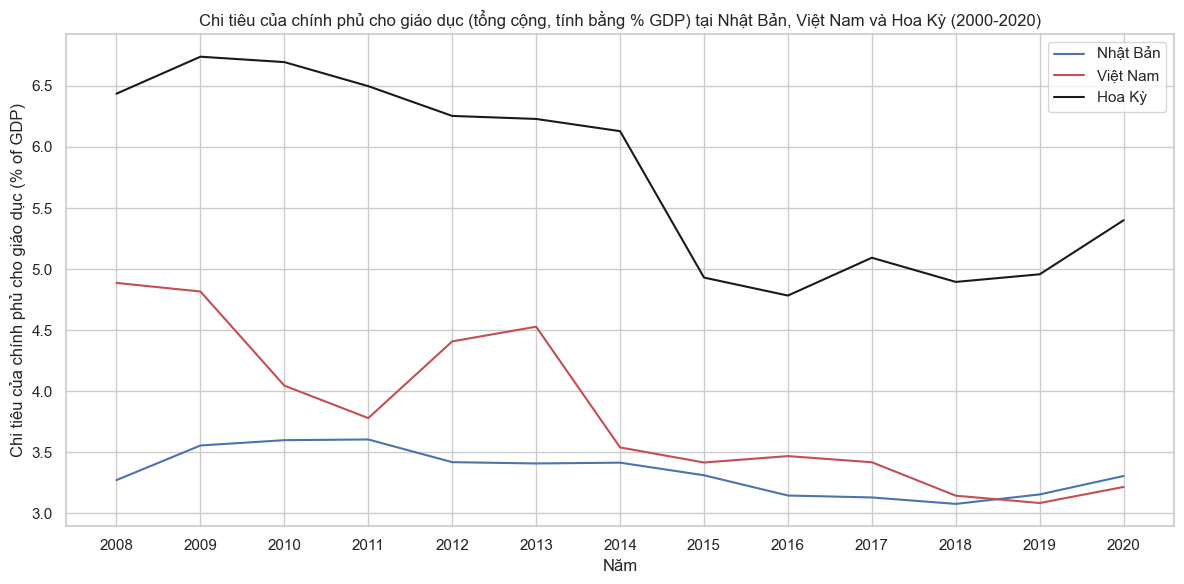

In [51]:
years = np.arange(2008, 2021)

plt.figure(figsize=(12, 6))
plt.plot(years, jp['SE_XPD_TOTL_GD_ZS'][8:21], 'b-', label='Nhật Bản')
plt.plot(years, vn['SE_XPD_TOTL_GD_ZS'][8:21], 'r-', label='Việt Nam')
plt.plot(years, us['SE_XPD_TOTL_GD_ZS'][8:21], 'k-', label='Hoa Kỳ')

plt.xticks(years)
plt.title('Chi tiêu của chính phủ cho giáo dục (tổng cộng, tính bằng % GDP) tại Nhật Bản, Việt Nam và Hoa Kỳ (2000-2020)')
plt.xlabel('Năm')
plt.ylabel('Chi tiêu của chính phủ cho giáo dục (% of GDP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('cau_1_giao_duc.svg')
plt.show()

**Nhận xét về chi tiêu của chính phủ cho giáo dục (tổng cộng, tính bằng % GDP) tại Nhật Bản, Việt Nam và Hoa Kỳ (2000-2020)**

- Ở **Nhật Bản (đường màu xanh)**, chi tiêu cho giáo dục của chính phủ dao động trong khoảng **3.1% - 3.6% GDP**, có xu hướng tổng thể **ổn định nhưng hơi giảm nhẹ**. Mức chi tiêu cao nhất là **khoảng 3.6% vào năm 2010**, trong khi mức thấp nhất là **khoảng 3.1% vào năm 2018**

- Ở **Việt Nam (đường màu đỏ)**, chi tiêu cho giáo dục dao động khá mạnh trong khoảng **3.0% - 4.9% GDP**, với xu hướng tổng thể **giảm dần theo thời gian**. Mức chi tiêu cao nhất đạt **gần 4.9% vào năm 2008**, nhưng sau đó giảm dần và đạt mức thấp nhất **khoảng 3.0% vào năm 2019**

- Ở **Hoa Kỳ (đường màu đen)**, chi tiêu cho giáo dục biến động trong khoảng **4.8% - 6.7% GDP**, có xu hướng tổng thể **giảm dần**. Mức cao nhất là khoảng **6.7% vào năm 2009**, sau đó giảm đáng kể xuống **4.8% vào năm 2015**, rồi phục hồi nhẹ vào năm 2020

**Kết luận**
- Nhật Bản có mức chi tiêu **ổn định** nhưng **thấp hơn** so với hai nước còn lại.

- Việt Nam có sự **sụt giảm** rõ rệt sau năm 2010. Điều này phản ánh sự thay đổi chính sách tài chính cho giáo dục.

- Hoa Kỳ có mức chi tiêu **cao nhất** trong ba nước nhưng có xu hướng **giảm mạnh** từ sau năm 2010.

#### **Câu 2:** Mối quan hệ giữa lực lượng lao động và tăng trưởng GDP hằng năm ở Việt Nam trong giai đoạn 2000-2020 là như thế nào? Liệu rằng khi lực lượng lao động tăng lên, GDP có xu hướng tăng trưởng theo không?


**Thuộc tính được sử dụng**
1. *NY_GDP_MKTP_KD_ZG* - Tăng trưởng GDP hàng năm (%).

2. *SL_TLF_TOTL_IN* - Lực lượng lao động.


**Các bước thực hiện**
1. Lấy dữ liệu từ bộ dữ liệu của Việt Nam cho hai chỉ số trên trong khoảng thời gian từ năm 2000 đến 2020.
2. Sử dụng biểu đồ đường để thể hiện sự biến động của tỷ lệ tăng trưởng GDP hằng năm qua các năm.
3. Vẽ biểu đồ kết hợp để quan sát xu hướng giữa tăng trưởng GDP và lực lượng lao động, sử dụng trục y kép để dễ dàng so sánh.
4. Tùy chỉnh trục, nhãn và tiêu đề cho biểu đồ.
5. Lưu biểu đồ dưới định dạng SVG và hiển thị kết quả.
6. Viết nhận xét.

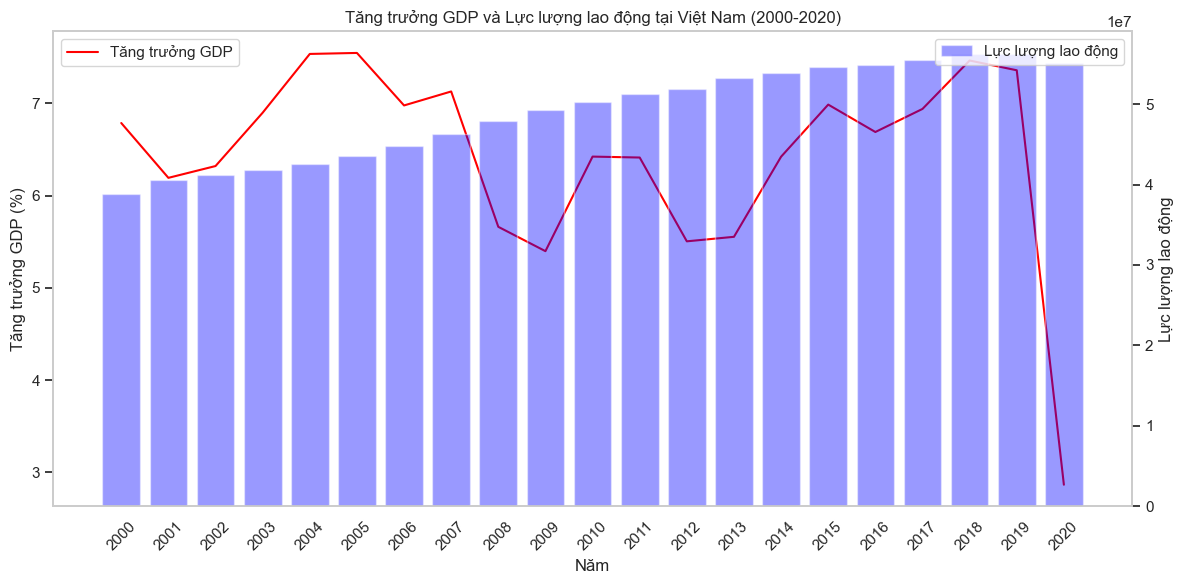

In [ ]:

fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()

ax1.plot(vn['year'], vn['NY_GDP_MKTP_KD_ZG'], label="Tăng trưởng GDP", color='red')
ax2.bar(vn['year'], vn['SL_TLF_TOTL_IN'], label="Lực lượng lao động", alpha=0.4, color='blue')

ax1.set_ylabel('Tăng trưởng GDP (%)')
ax2.set_ylabel('Lực lượng lao động')
ax1.set_xlabel('Năm')
ax1.set_xticks(vn['year']) 
ax1.tick_params(axis='x', rotation=45)  

ax1.set_title(f"Tăng trưởng GDP và Lực lượng lao động tại Việt Nam ({START_YEAR}-{END_YEAR})")

ax1.grid(False)
ax2.grid(False)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('cau_2.svg')
plt.show()

**Nhận xét về mối quan hệ giữa lực lượng lao động và tăng trưởng GDP hằng năm ở Việt Nam trong giai đoạn 2000-2020**

- Nhìn chung, lực lượng lao động tăng đều qua các năm nhưng tăng trưởng GDP thì lại biến động mạnh và không ổn định. Điều này cho thấy rằng tăng trưởng GPD không hoàn toàn tỷ lệ thuận với lực lượng lao động.

- Giai đoạn 2005–2009 và 2018-2020 là hai giai đoạn điển hình cho thấy GDP giảm dù lực lượng lao động vẫn tăng hoặc duy trì, cho thấy các yếu tố khác như khủng hoảng kinh tế hay dịch bệnh ảnh hưởng lớn đến tăng trưởng kinh tế.

**Kết luận**
-  lực lượng lao động không phải yếu tố duy nhất quyết định tăng trưởng GDP.

#### **Câu 3:** Tỷ trọng đóng góp của nông nghiệp, công nghiệp và dịch vụ vào GDP thay đổi ra sao trong khoảng 2000 đến 2020 của Việt Nam, Hoa Kỳ và Nhật Bản?

**Thuộc tính được sử dụng**

1. *NV_AGR_TOTL_ZS* - Giá trị gia tăng ngành nông nghiệp (% GDP)
2. *NV_IND_TOTL_ZS* - Giá trị gia tăng ngành công nghiệp (% GDP)
3. Dịch vụ được tính toán: 100 - Nông nghiệp - Công nghiệp

**Các bước thực hiện**

1. Lấy dữ liệu từ bộ dữ liệu của Việt Nam, Hoa Kỳ và Nhật Bản cho hai chỉ số trên trong khoảng thời gian 2000-2020.
2. Tính toán tỷ trọng ngành dịch vụ bằng công thức bù trừ.
3. Vẽ biểu đồ diện tích chồng (stacked area) để trực quan hóa tỷ trọng đóng góp của nông nghiệp, công nghiệp và dịch vụ vào GDP thay đổi trong giai đoạn 2000 đến 2020
4. Tùy chỉnh trục, nhãn và tiêu đề cho biểu đồ.
5. Lưu biểu đồ dưới định dạng SVG và hiển thị kết quả.
6. Viết nhận xét.

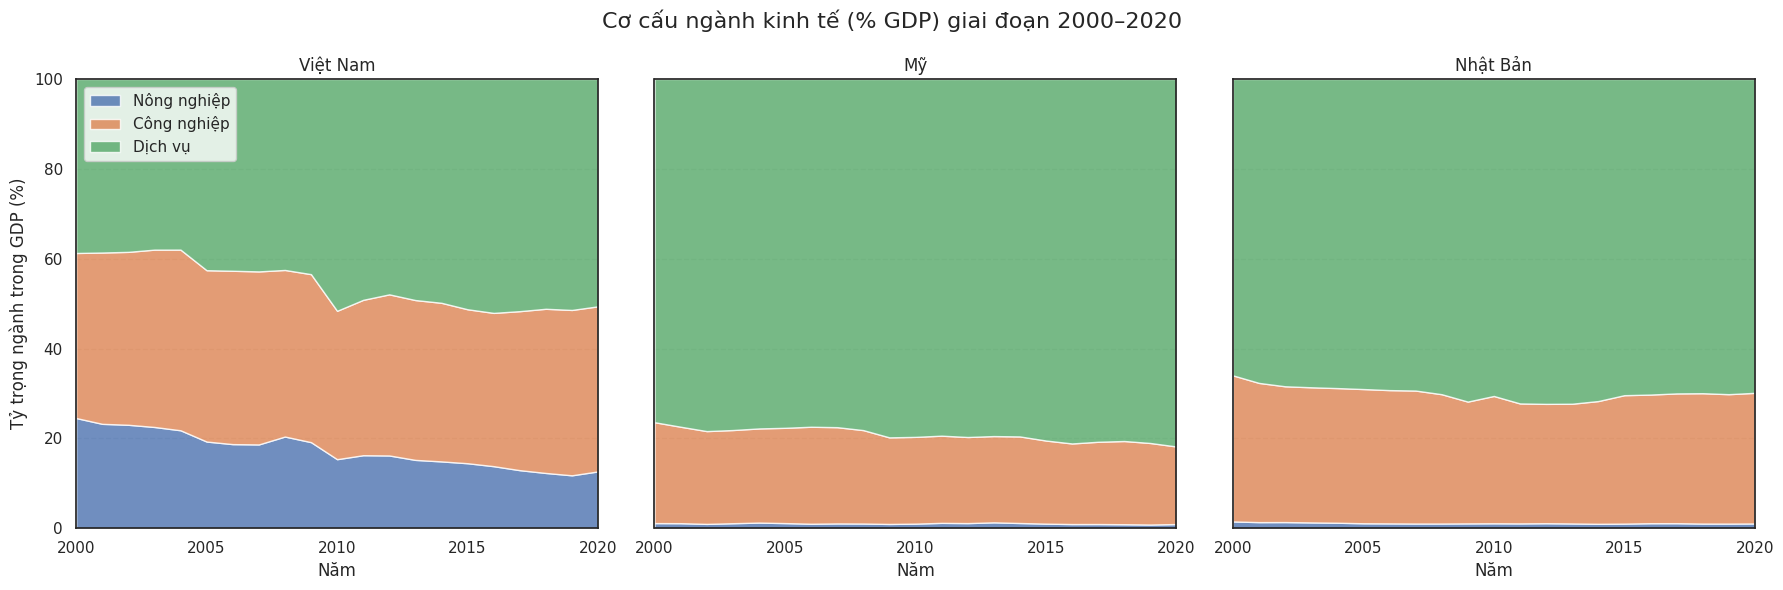

In [ ]:
categories = ['Nông nghiệp', 'Công nghiệp', 'Dịch vụ']
years = np.arange(2000, 2021)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (df, country) in zip(axes, [(vn, 'Việt Nam'), (us, 'Mỹ'), (jp, 'Nhật Bản')]):
    agri = df['NV_AGR_TOTL_ZS'].values
    indus = df['NV_IND_TOTL_ZS'].values
    service = 100 - agri - indus

    ax.stackplot(years, agri, indus, service, labels=categories, alpha=0.8)
    ax.set_title(country)
    ax.set_xlim(2000, 2020)
    ax.set_ylim(0, 100)
    ax.set_xlabel('Năm')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_xticks(np.arange(2000, 2021, 5))

axes[0].set_ylabel('Tỷ trọng ngành trong GDP (%)')
axes[0].legend(loc='upper left')
fig.suptitle('Cơ cấu ngành kinh tế (% GDP) giai đoạn 2000–2020', fontsize=16)
plt.tight_layout()
plt.savefig('cau_3.svg')
plt.show()

**Nhận xét về tỷ trọng đóng góp của nông nghiệp, công nghiệp và dịch vụ vào GDP thay đổi ra sao trong khoảng 2000 đến 2020 của Việt Nam, Hoa Kỳ và Nhật Bản?**

**Ở Việt Nam**
- Tỷ trọng nông nghiệp giảm mạnh từ ~25% xuống còn ~13%. Ngược lại, dịch vụ tăng rõ rệt, vượt công nghiệp từ năm 2011 và giữ vị trí cao nhất đến năm 2020.
- Công nghiệp có xu hướng tăng nhẹ, dao động quanh mức 35–38%.

**Ở Hoa Kỳ**
- Dịch vụ luôn chiếm ưu thế vượt trội (~80%) và ổn định trong suốt giai đoạn.
- Công nghiệp giảm nhẹ xuống dưới 20%, trong khi nông nghiệp duy trì mức rất thấp (~1%) và gần như không thay đổi.

**Ở Nhật Bản**
- Tương tự với Hoa Kỳ, nông nghiệp duy trì tỷ trọng rất thấp (dưới 2%) trong suốt giai đoạn.
- Dịch vụ giữ mức cao (~70%) và ổn định, trong khi công nghiệp giảm nhẹ nhưng vẫn chiếm khoảng 25–30%.

**Kết luận**
- Các nền kinh tế phát triển như Hoa Kỳ và Nhật Bản có cơ cấu kinh tế tập trung mạnh vào dịch vụ. Trong khi đó, Việt Nam đang trong quá trình chuyển dịch cơ cấu, với xu hướng giảm phụ thuộc vào nông nghiệp và tăng tỷ trọng dịch vụ.

### **Chủ đề Biến đổi khí hậu**

#### **Câu 4:** Biến động tiêu thụ năng lượng điện và năng lượng sơ cấp đầu người ở Hoa Kỳ từ 2000–2020 như thế nào? Có năm nào vượt trội hoặc bất thường không?

**Thuộc tính được sử dụng**

1. *EG_USE_ELEC_KH_PC* – Tiêu thụ điện bình quân đầu người (kWh/người).
2. *EG_USE_PCAP_KG_OE* – Tiêu thụ năng lượng bình quân đầu người (kg dầu tương đương/người).

**Các bước thực hiện**

1. Trích xuất dữ liệu cho 2 chỉ số trên từ năm 2000–2020 từ bộ dữ liệu.
2. Vẽ biểu đồ hộp (box plot) để trực quan hóa sự phân bố của từng chỉ số trong giai đoạn 2000–2020.
3. Phân tích xem có năm nào là ngoại lệ (outlier) hoặc sự biến động có lớn không giữa các năm.
4. Tùy chỉnh trục, nhãn và tiêu đề cho biểu đồ.
5. Lưu biểu đồ dưới định dạng SVG và hiển thị kết quả.
6. Đưa ra nhận xét về mức độ ổn định trong tiêu thụ năng lượng và xu hướng thay đổi trong hai thập kỷ qua.

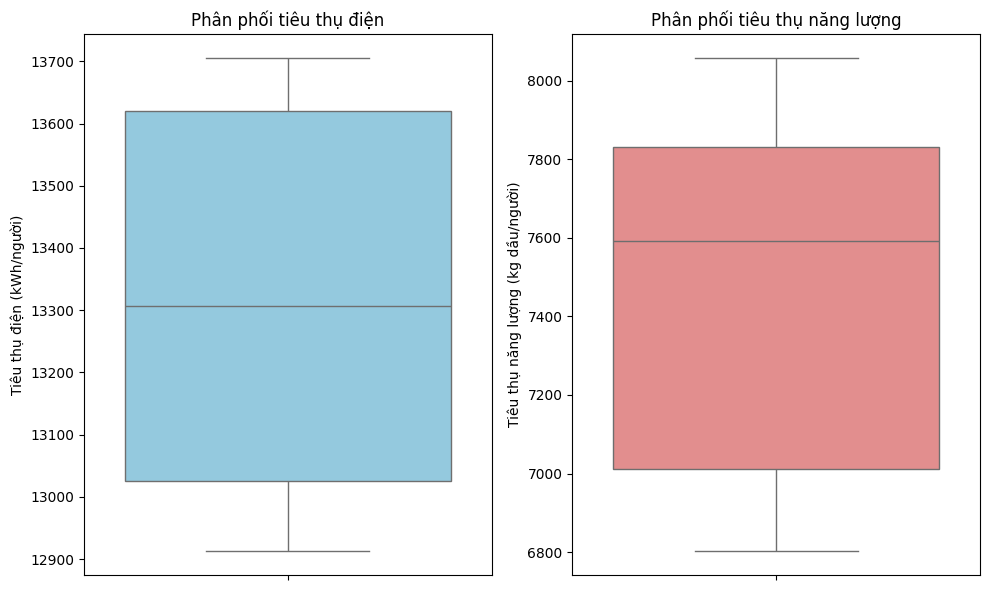

In [ ]:
fix, axes = plt.subplots(1, 2, figsize=(10, 6))

sns.boxplot(data=us['EG_USE_ELEC_KH_PC'], ax=axes[0], color='skyblue')
axes[0].set_title('Phân phối tiêu thụ điện')
axes[0].set_ylabel('Tiêu thụ điện (kWh/người)')

sns.boxplot(data=us['EG_USE_PCAP_KG_OE'], ax=axes[1], color='lightcoral')
axes[1].set_title('Phân phối tiêu thụ năng lượng')
axes[1].set_ylabel('Tiêu thụ năng lượng (kg dầu/người)')

plt.tight_layout()
plt.savefig('cau_4_khi_hau.svg')
plt.show()

**Nhận xét về phân phối tiêu thụ điện và năng lượng sơ cấp bình quân đầu người tại Hoa Kỳ (2000–2020)**

- **Tiêu thụ điện (kWh/người)** có phân phối khá hẹp, dao động chủ yếu trong khoảng **12900–13700 kWh/người**, với **trung vị khoảng 13300 kWh/người**. Không có giá trị ngoại lai rõ ràng, cho thấy mức tiêu thụ điện tương đối ổn định trong giai đoạn này. Khoảng tứ phân vị (IQR) không quá rộng, chứng tỏ sự dao động giữa các năm là nhỏ.

- **Tiêu thụ năng lượng sơ cấp (kg dầu/người)** có phân phối rộng hơn một chút, với giá trị dao động trong khoảng **6800–8100 kg dầu/người**. Trung vị rơi vào khoảng **7600 kg dầu/người**. Có vẻ như **phân phối hơi lệch về phía thấp** khi phần dưới của hộp (Q1–Median) dài hơn phần trên. Điều này phản ánh mức tiêu thụ năng lượng có sự sụt giảm nhẹ trong một vài năm (có thể do khủng hoảng hoặc chuyển dịch sang năng lượng tái tạo).

**Kết luận**

- Mức **tiêu thụ điện bình quân đầu người ở Hoa Kỳ khá ổn định** trong hai thập kỷ qua, phản ánh sự ổn định trong lối sống, hạ tầng và nhu cầu dân cư.

- Trong khi đó, **tiêu thụ năng lượng sơ cấp có xu hướng dao động mạnh hơn**, điều này có thể liên quan đến sự thay đổi trong chính sách năng lượng, công nghệ tiết kiệm nhiên liệu, và xu hướng sử dụng năng lượng tái tạo.

- **Không có giá trị ngoại lai rõ rệt** trong cả hai biểu đồ, cho thấy dữ liệu tương đối 'sạch' và không có biến động đột ngột bất thường.


#### **Câu 5**: Tỷ lệ dân số sống ở khu vực đô thị của Hoa Kỳ, Nhật Bản và Việt Nam đã thay đổi như thế nào từ năm 2000 đến năm 2020?
**Thuộc tính được sử dụng**

1. *SP_URB_TOTL_IN_ZS* – Tiêu thụ điện bình quân đầu người (kWh/người)

**Các bước thực hiện**

1. Trích xuất dữ liệu cho chỉ số *SP_URB_TOTL_IN_ZS* của ba quốc gia Hoa Kỳ (US), Nhật Bản (JP), và Việt Nam (VN) từ năm 2000 đến 2020.
2. Tạo DataFrame gồm các cột: *Year*, *US*, *JP*, *VN* tương ứng với từng quốc gia.
3. Sử dụng biểu đồ miền (area plot) kết hợp đường line để trực quan hóa xu hướng thay đổi theo thời gian.
4. Tùy chỉnh trục, nhãn và tiêu đề cho biểu đồ.
5. Lưu biểu đồ dưới định dạng SVG và hiển thị kết quả.
6. Nhận xét.

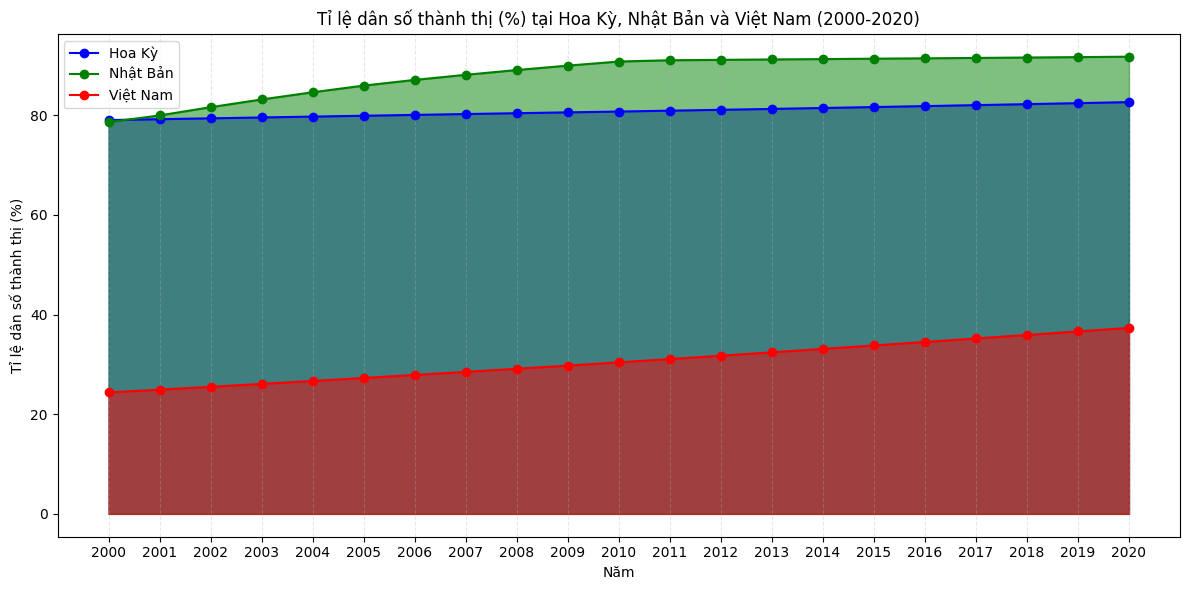

In [ ]:
df = pd.DataFrame(data={
    'Year': np.arange(2000, 2021),
    'US': us['SP_URB_TOTL_IN_ZS'],
    'JP': jp['SP_URB_TOTL_IN_ZS'],
    'VN': vn['SP_URB_TOTL_IN_ZS']
})

plt.figure(figsize=(12, 6))
plt.fill_between(df['Year'], df['US'], color="blue", alpha=0.5)
plt.plot(df['Year'], df['US'], color="blue", label='Hoa Kỳ', marker='o')
plt.fill_between(df['Year'], df['JP'], color="green", alpha=0.5)
plt.plot(df['Year'], df['JP'], color="green", label='Nhật Bản', marker='o')
plt.fill_between(df['Year'], df['VN'], color="red", alpha=0.5)
plt.plot(df['Year'], df['VN'], color="red", label='Việt Nam', marker='o')

plt.xticks(df['Year'])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.title('Tỉ lệ dân số thành thị (%) tại Hoa Kỳ, Nhật Bản và Việt Nam (2000-2020)')
plt.xlabel('Năm')
plt.ylabel('Tỉ lệ dân số thành thị (%)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('cau_5_khi_hau.svg')
plt.show()

**Nhận xét về tỉ lệ dân số thành thị tại Hoa Kỳ, Nhật Bản và Việt Nam (2000–2020)**

- **Hoa Kỳ** có tỷ lệ dân số thành thị khá **ổn định**, dao động trong khoảng **79% đến 83%**. Đường biểu diễn cho thấy mức tăng nhẹ qua thời gian, phản ánh sự phát triển đều và ổn định về đô thị hóa.

- **Nhật Bản** là quốc gia có **tỷ lệ đô thị hóa cao nhất** trong ba nước, vượt mốc **90%** từ sau năm 2010 và duy trì ở mức **91–92%** đến năm 2020. Quá trình đô thị hóa của Nhật Bản diễn ra nhanh giai đoạn đầu và dần bão hòa.

- **Việt Nam** có tỷ lệ đô thị hóa thấp nhất nhưng lại tăng nhanh nhất, từ mức **~25% năm 2000** lên gần **38% vào năm 2020**. Biểu đồ cho thấy xu hướng tăng rõ rệt, đặc biệt sau năm 2010, phản ánh sự chuyển dịch mạnh mẽ từ nông thôn sang đô thị.

**Kết luận**

- **Nhật Bản** đã đạt mức đô thị hóa rất cao và gần như ổn định trong thập kỷ qua.
- **Hoa Kỳ** giữ mức độ đô thị hóa cao, với đà tăng chậm và đều.
- **Việt Nam** đang trong giai đoạn tăng tốc mạnh về đô thị hóa, thể hiện xu hướng phát triển kinh tế – xã hội nhanh chóng.

#### **Câu 6:** Mối quan hệ giữa quy mô dân số và tổng lượng điện năng tiêu thụ của Việt Nam từ năm 2000 đến 2020 thay đổi như thế nào? Những năm nào cho thấy sự tăng trưởng đột phá về nhu cầu điện tính trên đầu người?

**Thuộc tính được sử dụng**

1. *EG_USE_ELEC_KH_PC* – Tiêu thụ điện bình quân đầu người (kWh/người)
2. *SP_POP_TOTL* – Tổng dân số

**Các bước thực hiện**

1. Trích xuất dữ liệu của Việt Nam từ năm 2000 đến 2020 cho hai chỉ số: dân số (`SP_POP_TOTL`) và tiêu thụ điện bình quân đầu người (`EG_USE_ELEC_KH_PC`).
2. Tính tổng lượng điện năng tiêu thụ bằng cách nhân hai chỉ số.
3. Tạo biểu đồ Bubble Plot:
   - Trục X: Dân số
   - Trục Y: Tiêu thụ điện bình quân đầu người
   - Kích thước bong bóng: Tổng lượng điện tiêu thụ
   - Nhãn từng năm giúp nhận diện các mốc thời gian cụ thể
4. Tùy chỉnh trục, nhãn và tiêu đề cho biểu đồ.
5. Lưu biểu đồ dưới định dạng SVG và hiển thị kết quả.
6. Nhận xét biểu đồ.


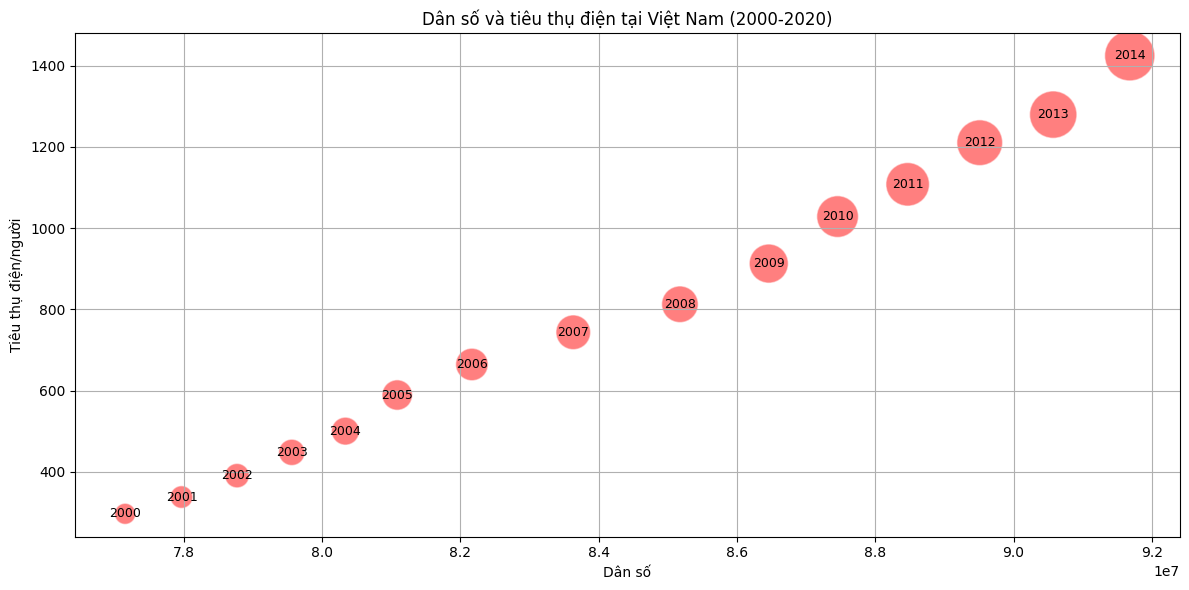

In [ ]:
df = pd.DataFrame(data={
    'Year': np.arange(2000, 2021),
    'SP_POP_TOTL': vn['SP_POP_TOTL'],
    'EG_USE_ELEC_KH_PC': vn['EG_USE_ELEC_KH_PC']
})

df['TOTL_ELEC'] = df['SP_POP_TOTL'] * df['EG_USE_ELEC_KH_PC']

plt.figure(figsize=(12, 6))
plt.scatter(df['SP_POP_TOTL'], df['EG_USE_ELEC_KH_PC'], 
            s=df['TOTL_ELEC'] / 100000000.5, 
            alpha=0.5, c='red', edgecolors="w", linewidth=1)

for i in range(len(df)):
    x = df['SP_POP_TOTL'][i]
    y = df['EG_USE_ELEC_KH_PC'][i]
    year = df['Year'][i]

    if np.isfinite(x) and np.isfinite(y):
        plt.text(x, y, str(year), fontsize=9, ha='center', va='center', color='black')


plt.title('Dân số và tiêu thụ điện tại Việt Nam (2000-2020)')
plt.xlabel('Dân số')
plt.ylabel('Tiêu thụ điện/người')
plt.grid(True)
plt.tight_layout()
plt.savefig('cau_6_khi_hau.svg')
plt.show()

**Nhận xét về dân số và tiêu thụ điện tại Việt Nam (2000–2020)**

- **Giai đoạn 2000–2014**: Dữ liệu cho thấy **cả dân số và tiêu thụ điện/người đều tăng mạnh mẽ**.  
  - Dân số tăng từ khoảng **77 triệu (năm 2000)** lên gần **92 triệu (năm 2014)**.  
  - Tiêu thụ điện/người tăng từ khoảng **300 kWh/người lên hơn 1400 kWh/người**.  
  - Điều này cho thấy mức sống và nhu cầu sử dụng điện tăng rõ rệt, phản ánh quá trình **công nghiệp hóa và hiện đại hóa** đất nước.

- **Tốc độ tăng tiêu thụ điện/người vượt xa tốc độ tăng dân số**, cho thấy nhu cầu điện không chỉ đến từ dân cư mà còn từ hoạt động sản xuất, kinh doanh.

- **Kích thước bong bóng** (biểu thị tổng sản lượng điện tiêu thụ) cũng tăng theo thời gian, khẳng định mức tiêu thụ điện toàn quốc tăng mạnh.

- **Xu hướng tăng đều** và ổn định qua từng năm từ 2000 đến 2014, không có năm nào bị gián đoạn hoặc sụt giảm.

**Lưu ý**:  
Do **thiếu dữ liệu về tiêu thụ điện đầu người từ năm 2015 trở đi**, nên biểu đồ **không hiển thị** từ năm 2015 đến 2020.

**Kết luận**

- Việt Nam đang trong quá trình **tăng trưởng mạnh về nhu cầu sử dụng điện**, phù hợp với đà phát triển kinh tế và đô thị hóa.  
- Sự tăng nhanh về tiêu thụ điện/người là chỉ dấu tích cực về **mức sống, công nghệ và công nghiệp hóa** tại Việt Nam trong giai đoạn 2000–2014.

### **Chủ đề Kinh tế & Phát triển**

#### **Câu 7**: Tình hình tăng trưởng GDP của Hoa Kỳ qua các năm (2000-2020)

**Thuộc tính được sử dụng**

1. *year* - Năm từ 2000 đến 2020.
2. *NY_GDP_MKTP_KD_ZG* - Tăng trưởng GDP hàng năm của Hoa Kỳ (% thay đổi so với năm trước).

**Các bước thực hiện**

1. Lấy dữ liệu tăng trưởng GDP hàng năm (`NY_GDP_MKTP_KD_ZG`) của Hoa Kỳ từ bộ dữ liệu cho giai đoạn 2000-2020.
2. Tạo biểu đồ cột ngang bằng cách sử dụng year làm trục y và `NY_GDP_MKTP_KD_ZG` làm trục x.
3. Tùy chỉnh biểu đồ: đặt tiêu đề, nhãn trục, giới hạn trục x dựa trên giá trị lớn nhất của tăng trưởng GDP, thêm lưới trục x, và sử dụng màu sắc có điều kiện để phân biệt tăng trưởng dương/âm.
4. Điều chỉnh bố cục biểu đồ để đảm bảo các nhãn hiển thị đầy đủ và không bị cắt.
5. Hiển thị biểu đồ và đưa ra nhận xét dựa trên xu hướng quan sát được.

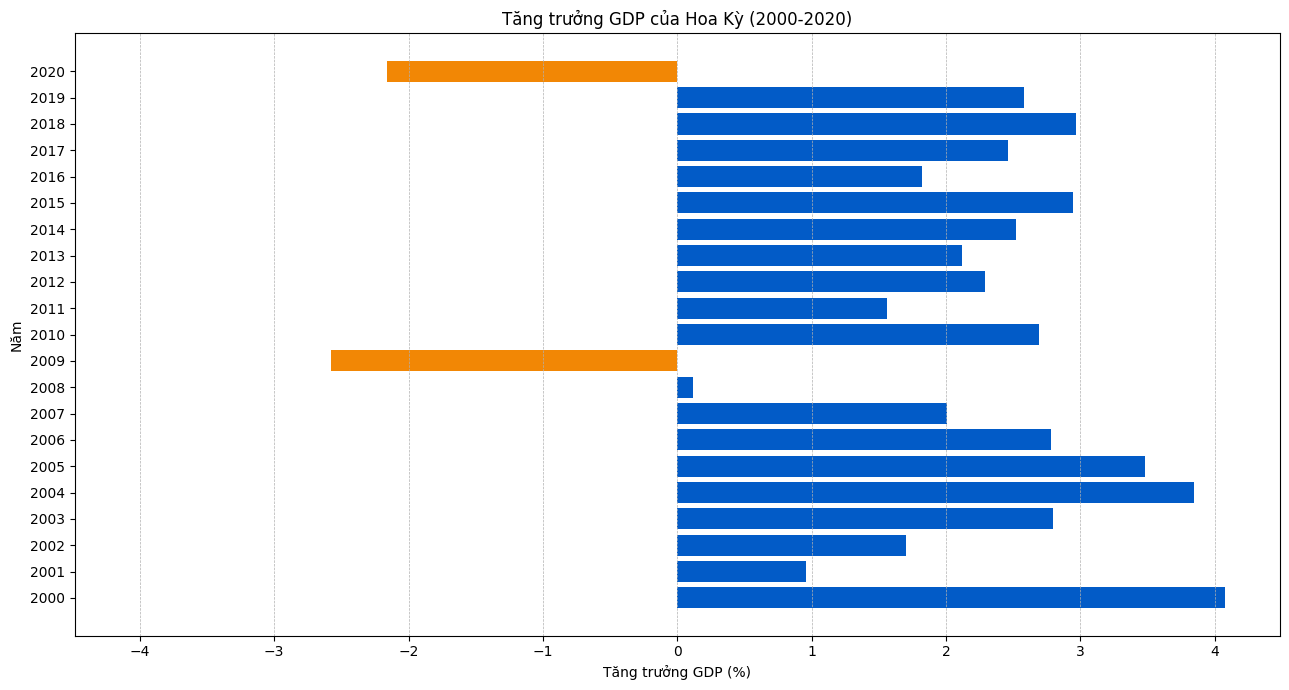

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))

ax.barh(us['year'], us['NY_GDP_MKTP_KD_ZG'], color=np.where(us['NY_GDP_MKTP_KD_ZG'] < 0, '#f28705', '#025bc7'))
ax.set_title(label='Tăng trưởng GDP của Hoa Kỳ (2000-2020)')
ax.set_xlabel(xlabel='Tăng trưởng GDP (%)')
ax.set_ylabel(ylabel='Năm')

ax.set_xlim(-max(us['NY_GDP_MKTP_KD_ZG']) * 1.1, max(us['NY_GDP_MKTP_KD_ZG']) * 1.1)
ax.set_yticks(ticks=range(2000, 2021), labels=range(2000, 2021))
ax.grid(axis='x', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('cau_7_kinh_te.svg')
plt.show()

**Nhận xét**

- Về tổng quan, nền kinh tế Hoa Kỳ phát triển mạnh mẽ khi hầu hết mức tăng trưởng GDP qua các năm đều dương cùng sự phục hồi mạnh mẽ khi mức GPD tăng vọt chỉ sau 1 năm suy thoái.
- Trong tất cả các năm từ 2000 đến 2020, chỉ có 2 năm mức tăng trưởng GDP của Mỹ đạt mức âm, đó là năm 2009 và năm 2020.
    - Năm 2009: Năm này hứng chịu mọi hậu quả của cuộc khủng hoảng tài chính toàn cầu, xuất phát từ việc **Lehman Brothers phá sản** - công tỳ dịch vụ tài chính toàn cầu.
    - Năm 2020: Đại dịch COVID-19 bùng phát dẫn đến phong tỏa diện rộng, tỷ lệ thất nghiệp tăng mạnh (14.7% - mức cao nhất kể từ Đại suy thoái năm 2009) và sụ sụt giảm tiêu dùng.

#### Câu 8: Tỷ lệ xuất nhập khẩu của Hoa Kỳ ảnh hưởng đến sự tăng trưởng GDP như thế nào (2000 - 2020)?

**Thuộc tính được sử dụng**

1. *NE_EXP_GNFS_ZS*-  Tỷ lệ xuất khẩu hàng hóa và dịch vụ (% GDP).
2. *NE_IMP_GNFS_ZS* - Tỷ lệ nhập khẩu hàng hóa và dịch vụ (% GDP).
3. *NY_GDP_MKTP_KD_ZG* - Tăng trưởng GDP hàng năm (% thay đổi so với năm trước)

**Các bước thực hiện**

1. Lấy dữ liệu từ bộ dữ liệu của Hoa Kỳ cho ba chỉ số *NE_EXP_GNFS_ZS*, *NE_IMP_GNFS_ZS* và *NY_GDP_MKTP_KD_ZG* trong giai đoạn 2000-2020.
2. Vẽ biểu đồ phân tán với *NE_EXP_GNFS_ZS* trên trục x, *NE_IMP_GNFS_ZS* trên trục y và sử dụng *NY_GDP_MKTP_KD_ZG* để xác định kích thước và màu sắc của các điểm.
3. Tùy chỉnh biểu đồ: thêm tiêu đề, nhãn trục, chú thích (legend) cho tăng trưởng GDP, và lưới nền để dễ quan sát.
4. Điều chỉnh bố cục biểu đồ để đảm bảo các thành phần hiển thị rõ ràng và không bị cắt.
5. Hiển thị biểu đồ và đưa ra nhận xét về mối quan hệ giữa tỷ lệ xuất nhập khẩu và tăng trưởng GDP dựa trên xu hướng quan sát được.

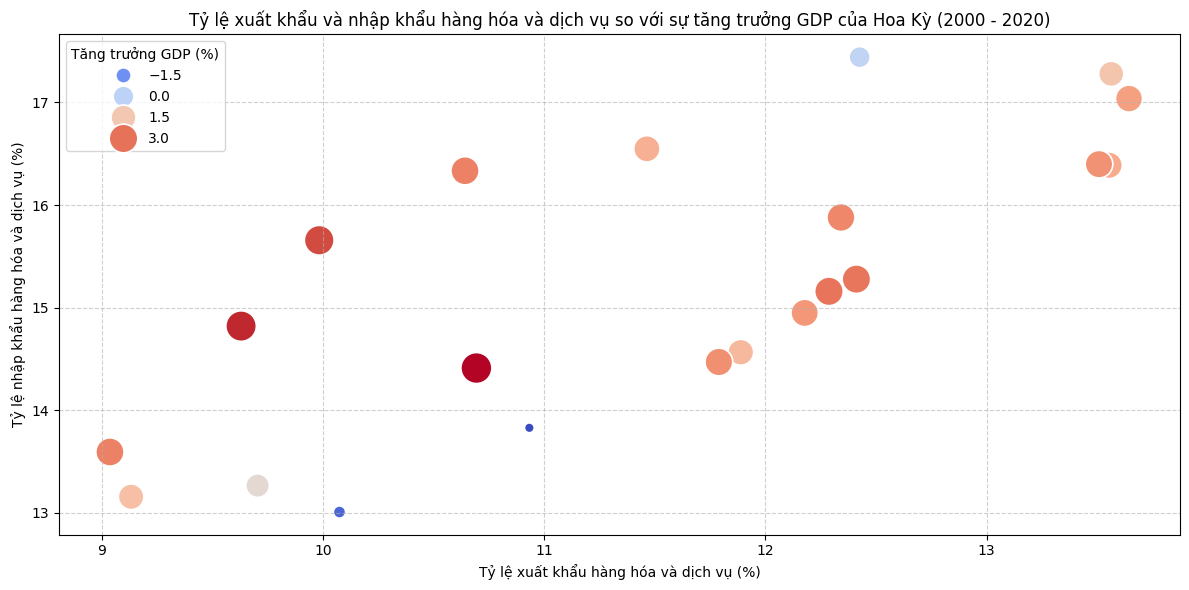

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='NE_EXP_GNFS_ZS', y='NE_IMP_GNFS_ZS', size='NY_GDP_MKTP_KD_ZG',
                sizes=(50, 500), data=us, hue='NY_GDP_MKTP_KD_ZG', palette='coolwarm')
plt.title(label='Tỷ lệ xuất khẩu và nhập khẩu hàng hóa và dịch vụ so với sự tăng trưởng GDP của Hoa Kỳ (2000 - 2020)')
plt.xlabel(xlabel='Tỷ lệ xuất khẩu hàng hóa và dịch vụ (%)')
plt.ylabel(ylabel='Tỷ lệ nhập khẩu hàng hóa và dịch vụ (%)')
plt.legend(title='Tăng trưởng GDP (%)', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('cau_8_kinh_te.svg')
plt.show()

In [ ]:
us[(us['NE_IMP_GNFS_ZS'] > 17) & (us['NE_EXP_GNFS_ZS'] < 13)]

,year,AG_LND_AGRI_ZS,AG_LND_ARBL_ZS,AG_LND_EL5M_ZS,AG_LND_FRST_K2,AG_LND_FRST_ZS,AG_LND_IRIG_AG_ZS,AG_YLD_CREL_KG,BM_GSR_ROYL_CD,BN_CAB_XOKA_CD,...,SE_XPD_TERT_PC_ZS,SE_XPD_TOTL_GD_ZS,SL_TLF_TOTL_FE_ZS,SL_TLF_TOTL_IN,SL_UEM_TOTL_FE_ZS,SL_UEM_TOTL_ZS,SP_POP_GROW,SP_POP_TOTL,SP_URB_TOTL,SP_URB_TOTL_IN_ZS
8,2008,45.13,17.69,NaN,3076832.00,33.64,5.41,6598.30,27764000000.00,-696526000000.00,...,NaN,6.44,45.31,158272885.00,5.41,5.78,0.95,304093966.00,244607104.00,80.44


**Nhận xét**
- Dựa vào biểu đồ trên, ta nhận thấy tỷ lệ xuất khẩu và tỷ lệ nhập khẩu có tương quan thuận, cùng tương quan thuận **nhẹ** với sự tăng trưởng GDP.
- Bên cạnh đó, Hoa Kỳ còn khá phụ thuộc vào nhập khẩu khi tỷ lệ nhập khẩu cao tác động thuận đến mức độ tăng trưởng GDP nhiều hơn tỷ lệ xuất khẩu.
- Đặc biệt, vào năm 2008, khi xảy ra khủng hoảng kinh tế, dù tỷ lệ xuất nhập khẩu khá cao, song vẫn chịu mức tăng trưởng GDP gần 0.

#### Câu 9: Làm thế nào để gom nhóm các nền kinh tế trên thế giới và đưa gợi ý phát triển cho các nhóm nền kinh tế (năm 2023)?

**Thuộc tính được sử dụng**

1. *NY_GDP_MKTP_CD* - Tổng GDP (theo USD hiện hành).
2. *NY_GDP_MKTP_KD_ZG* - Tăng trưởng GDP hàng năm (% thay đổi so với năm trước).
3. *NY_GDP_PCAP_CD* - GDP bình quân đầu người (theo USD hiện hành).
4. *NY_GNP_ATLS_CD* - Tổng thu nhập quốc dân (GNI) theo phương pháp Atlas (theo USD hiện hành).

**Các bước thực hiện**

1. Trích xuất dữ liệu từ World Bank cho 12 quốc gia vào năm 2023, với 4 chỉ số: *NY_GDP_MKTP_CD*, *NY_GDP_MKTP_KD_ZG*, *NY_GDP_PCAP_CD*, và *NY_GNP_ATLS_CD*.
2. Chuẩn hóa dữ liệu bằng *StandardScaler* để đảm bảo các chỉ số có cùng thang đo, tránh ảnh hưởng của sự khác biệt về đơn vị.
3. Thử nghiệm thuật toán *KMeans* với số lượng cụm (k) từ 2 đến 10, tính toán *Inertia* và *Silhouette Score* cho từng giá trị k, sau đó vẽ biểu đồ đường để xác định số lượng cụm tối ưu.
4. Chọn k (dựa trên biểu đồ *Inertia* và *Silhouette Score*) và áp dụng KMeans để gom nhóm các quốc gia thành k cụm.
5. Vẽ biểu đồ violin để trực quan hóa phân phối của từng chỉ số kinh tế theo cụm, tùy chỉnh nhãn, tiêu đề và màu sắc.
6. Phân tích đặc điểm của từng cụm và đưa ra gợi ý phát triển phù hợp.

In [ ]:
LS_SD_INDICATORS = ['NY.GDP.MKTP.CD', 'NY.GDP.MKTP.KD.ZG', 'NY.GDP.PCAP.CD', 'NY.GNP.ATLS.CD']
LS_SD_COUNTRIES = [
    'EGY', 'LBR', 'GHA',
    'CHN', 'IND', 'VNM',
    'DNK', 'FRA', 'ESP',
    'CAN', 'USA', 'MEX'
]

ls_sd = pd.DataFrame()
for country in LS_SD_COUNTRIES:
    data = wb.data.DataFrame(
        series=LS_SD_INDICATORS,
        economy=country,
        time=2023,
    )
    ls_sd = pd.concat(objs=[ls_sd, data], axis=0)

ls_sd.columns = ls_sd.columns.str.replace('.', '_')
ls_sd

,NY_GDP_MKTP_CD,NY_GDP_MKTP_KD_ZG,NY_GDP_PCAP_CD,NY_GNP_ATLS_CD
economy,,,,
EGY,396002496996.96,3.76,3457.46,439283081783.31
LBR,4240000000.00,4.68,771.89,3917869127.29
GHA,76370396722.15,2.94,2260.29,79823496732.60
CHN,17794783039552.00,5.25,12614.06,18883066161555.50
IND,3567551674623.01,8.15,2480.79,3649300224484.68
VNM,429716969043.57,5.05,4282.09,412944119222.27
DNK,407091920305.40,2.50,68453.88,436164758696.37
FRA,3051831611384.76,0.94,44690.93,3085396612969.70
ESP,1620090734956.89,2.68,33509.01,1587224535631.87


In [ ]:
ls_sd_scale = pd.DataFrame(data=StandardScaler().fit_transform(ls_sd), columns=ls_sd.columns)
ls_sd_scale

,NY_GDP_MKTP_CD,NY_GDP_MKTP_KD_ZG,NY_GDP_PCAP_CD,NY_GNP_ATLS_CD
0,-0.54,0.08,-0.84,-0.54
1,-0.59,0.57,-0.94,-0.60
2,-0.58,-0.35,-0.89,-0.59
3,1.55,0.87,-0.51,1.68
4,-0.16,2.41,-0.88,-0.16
5,-0.54,0.76,-0.81,-0.55
6,-0.54,-0.59,1.50,-0.54
7,-0.22,-1.42,0.64,-0.22
8,-0.40,-0.49,0.24,-0.40
9,-0.33,-1.25,0.96,-0.33


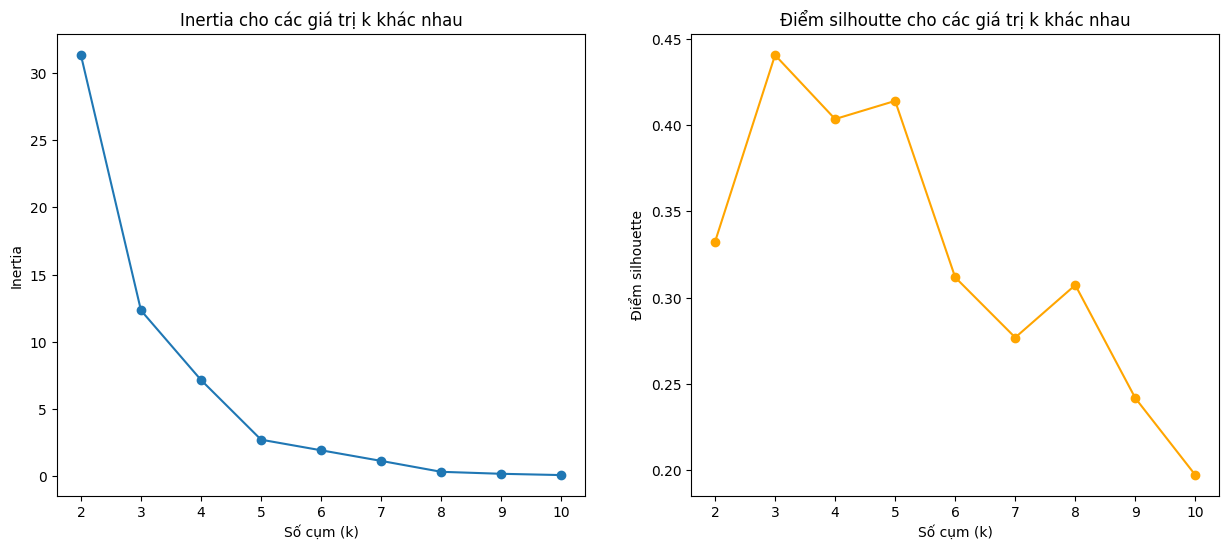

In [ ]:
inertias = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=2, max_iter=1000)
    cluster_labels = kmeans.fit_predict(ls_sd_scale)
    silhouette_scores.append(silhouette_score(ls_sd_scale, cluster_labels))
    inertias.append(kmeans.inertia_)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(k_values, inertias, marker='o')
axes[0].set_title(label='Inertia cho các giá trị k khác nhau')
axes[0].set_xlabel('Số cụm (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_xticks(ticks=k_values)

axes[1].plot(k_values, silhouette_scores, marker='o', color='orange')
axes[1].set_title('Điểm silhoutte cho các giá trị k khác nhau')
axes[1].set_xlabel('Số cụm (k)')
axes[1].set_ylabel('Điểm silhouette')
axes[1].set_xticks(ticks=k_values)
plt.savefig('cau_9_kinh_te_I_S.svg')
plt.show()

**Nhận xét**
- Dựa vào biểu đồ thể hiện giá trị inertia và điểm silhouette cho các giá trị **k** khác nhau, `k = 3` cho điểm silhouette cao nhất nhưng độ giảm giá trị inertia nhiều hơn `k = 5`, còn `k = 5` tuy cho điểm silhoutte thấp hơn nhưng độ giảm giá trị inertia khá đáng kể. Sau khi cân nhắc, nhóm quyết định sử dụng `k = 3` là số lượng phù hợp hơn để chia các nhóm nền kinh tế.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=2, max_iter=1000)
cluster_labels = kmeans.fit_predict(ls_sd_scale)
cluster_labels

array([0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 2, 0])

In [ ]:
ls_sd['cluster'] = cluster_labels
ls_sd.head()

,NY_GDP_MKTP_CD,NY_GDP_MKTP_KD_ZG,NY_GDP_PCAP_CD,NY_GNP_ATLS_CD,cluster
economy,,,,,
EGY,396002496996.96,3.76,3457.46,439283081783.31,0
LBR,4240000000.00,4.68,771.89,3917869127.29,0
GHA,76370396722.15,2.94,2260.29,79823496732.60,0
CHN,17794783039552.00,5.25,12614.06,18883066161555.50,2
IND,3567551674623.01,8.15,2480.79,3649300224484.68,0


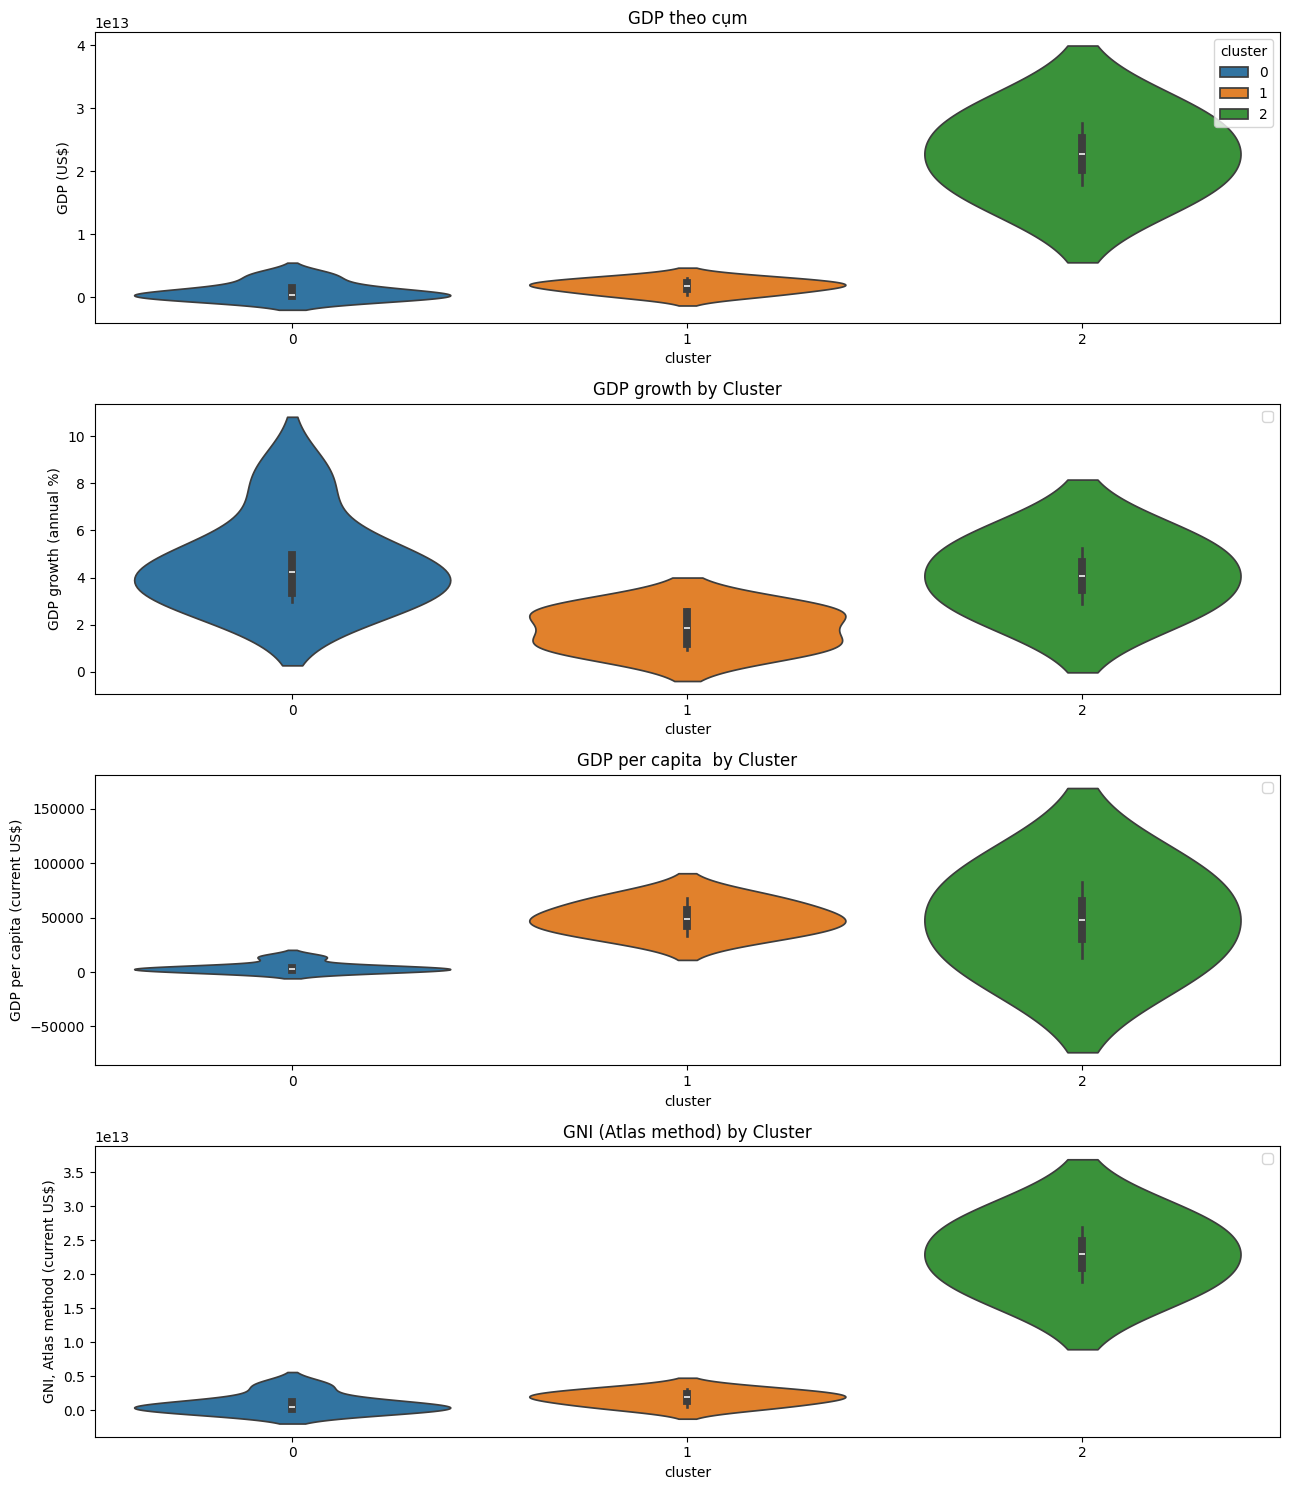

In [ ]:
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c'}  # Green

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(13, 15))

sns.violinplot(x= ls_sd['cluster'], y=ls_sd['NY_GDP_MKTP_CD'], palette=cluster_colors, hue=ls_sd['cluster'], ax=axes[0])
axes[0].set_title(label='GDP theo cụm')
axes[0].set_ylabel('GDP (US$)')

sns.violinplot(x= ls_sd['cluster'], y=ls_sd['NY_GDP_MKTP_KD_ZG'], palette=cluster_colors, hue=ls_sd['cluster'], ax=axes[1])
axes[1].set_title('Tăng trưởng GDP theo cụm')
axes[1].set_ylabel('Tẳng trưởng GDP (%)')
axes[1].legend('')

sns.violinplot(x= ls_sd['cluster'], y=ls_sd['NY_GDP_PCAP_CD'], palette=cluster_colors, hue=ls_sd['cluster'], ax=axes[2])
axes[2].set_title('GDP bình quân đầu người theo cụm')
axes[2].set_ylabel('GDP bình quân đầu người (Tính theo tỷ giá đồng Dollar hiện tại)')
axes[2].legend('')

sns.violinplot(x= ls_sd['cluster'], y=ls_sd['NY_GNP_ATLS_CD'], palette=cluster_colors, hue=ls_sd['cluster'], ax=axes[3])
axes[3].set_title('GNI theo cụm')
axes[3].set_ylabel('GNI (Tính theo tỷ giá đồng Dollar hiện tại)')
axes[3].legend('')

plt.tight_layout()
plt.savefig('cau_9_kinh_te.svg')
plt.show()

**Nhận xét các nền kinh tế năm 2023**

- **Nhóm 0** là nhóm các nền kinh tế **đang phát triển**
    - **Đặc điểm**:
        - `GDP` và `GNI` thấp nhất trong cả 3 nhóm, thể hiện:
            - Sản xuất kém phát triển, quy mô nhỏ.
            - Cơ hội việc làm hạn chế, chất lượng lao động thấp.
            - Thiếu nguồn thu từ nước ngoài và đầu tư quốc tế.
        - `Tăng trưởng GDP` dao động mạnh, có nền kinh tế tăng trưởng nhanh nhưng cũng có nền kinh tế bị trì trệ.
        - `GDP bình quân đầu người` thấp phản ánh mức sống kém.
    - **Gợi ý phát triển**:
        - Đầu tư phát triển cơ sở hạ tầng (giao thông, viễn thông,...).
        - Áp dụng các chính sách khuyến khích đầu tư nước ngoài.

- Nhóm 1 là nhóm các nền kinh tế **mới nổi**
    - **Đặc điểm**:
        - `GDP` và `GNI` dù cao hơn nhóm 0 nhưng vẫn khá thấp.
        - `Tăng trưởng GDP` ít dao động, thể hiện nền kinh tế ổn định nhưng thiếu sự đột phá.
        - `GDP bình quân đầu người` ở mức trung bình, vẫn còn tiềm năng để nâng cao mức sống.
    - **Gợi ý phát triển**:
        - Đầu tư phát triển giáo dực và khả năng truy cập kỹ thuật số.
        - Đa dạng hóa nền kinh tế bằng cách chuyển từ nên kinh tế phát triển tập trung sang nền kinh tế dựa vào tri thức.

- Nhóm 2 là nhóm Các nền kinh tế **phát triển**
    - **Đặc điểm**:
        - `GDP` và `GNI` cao nhất trong 3 nhóm, thể hiện:
            - Sản xuất mạnh mẽ với quy mô lớn.
            - Chất lượng sản xuất và chất lượng lao động tốt.
            - Vị thế trên thị trường quốc tế.
        - `Tăng trưởng GDP` ảm đạm hơn nhóm 1, thể hiện nền kinh tế ổn định với nhiều hơn những đột phá.
        - `GDP bình quân đầu người` cao nhất, phản ánh mức sống cao cùng cơ sở hạ tầng hiện đại.
    - **Gợi ý phát triển**:
        - Đầu tư phát triển công nghệ, AI.
        - Áp dụng các chính sách thúc đẩy tính bền vững, xu thế phát triển ngày nay.